<a href="https://colab.research.google.com/github/p-drozdowska/deep-learning-assignment/blob/main/Deep_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
# Check GPU
!nvidia-smi

Thu May 12 09:34:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install needed libraries
!pip install split-folders[full]

In [ ]:
# Import resources
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import splitfolders
import tensorflow as tf

from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from scipy.ndimage.interpolation import zoom

from sklearn.metrics import confusion_matrix


# Loading the dataset
Including loading the file and basic preparation.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unpack the dataset zip file
shutil.unpack_archive("/content/drive/MyDrive/CatsAndDogs.zip", "/content/dataset")

In [ ]:
# Remove corrupt files
os.remove("/content/dataset/PetImages/Dog/11702.jpg")
os.remove("/content/dataset/PetImages/Cat/666.jpg")

In [ ]:
# Split into training and test set folders
splitfolders.ratio("/content/dataset/PetImages/", output="/content/cats_dogs",
    seed=42, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 25000 files [00:04, 6248.15 files/s]


In [ ]:
# Rename the val folder
os.rename("/content/cats_dogs/val", "/content/cats_dogs/test")

# Exploratory data analysis & preprocessing

Prepare ImageDataGenerator for producing augmented batches of data

In [ ]:
# For training data
train_datagen = ImageDataGenerator(
    rescale=1./255, #rescales the images
    rotation_range=40, #range of degrees for random rotations
    width_shift_range=0.2, #range of % for random width change
    height_shift_range=0.2, #as above for height
    shear_range=0.2, #as above for shearing (change along bot the x and y directions)
    zoom_range=0.2, #as above for zooming in the image
    horizontal_flip=True, #allow horizontal flip
    fill_mode='nearest', #fills empty spaces with the nearest pixel value
    validation_split=0.2) #reserves fraction of unaugmented images for validation

# For validation data; no augmentation
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

Load the training and validation data in batches.

In [ ]:
directory = "/content/cats_dogs/train"
batch_size = 32

# Get training data
train_ds = train_datagen.flow_from_directory(
    directory,
    seed=42, # to ensure train/val split contains the same images in each flow
    target_size=(128, 128),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    subset='training')

# Get validation data
val_ds = val_datagen.flow_from_directory(
    directory,
    seed=42,
    target_size=(128, 128),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    subset='validation')

Found 16000 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.


Check the size of the dataset.

In [ ]:
train_dir = '/content/cats_dogs/train'
train_cat_dir = os.path.join(train_dir, 'Cat')
train_dog_dir = os.path.join(train_dir, 'Dog')

# Training images - minus the removed corrupted files
print(f"Total of training images: {len(os.listdir(train_cat_dir)) + len(os.listdir(train_dog_dir)) - 2}")
print(f"Of those, there are {len(os.listdir(train_cat_dir)) - 1} cat images and {len(os.listdir(train_dog_dir)) - 1} dog images. \n")

test_dir = '/content/cats_dogs/test'
test_cat_dir = os.path.join(test_dir, 'Cat')
test_dog_dir = os.path.join(test_dir, 'Dog')

print(f"Total of testing images: {len(os.listdir(test_cat_dir)) + len(os.listdir(test_dog_dir))}")
print(f"Of those, there are {len(os.listdir(test_cat_dir))} cat images and {len(os.listdir(test_dog_dir))} dog images. \n")

Total of training images: 19998
Of those, there are 9999 cat images and 9999 dog images. 

Total of testing images: 5000
Of those, there are 2500 cat images and 2500 dog images. 



Get a plot displaying the numbers of images in each set and class.

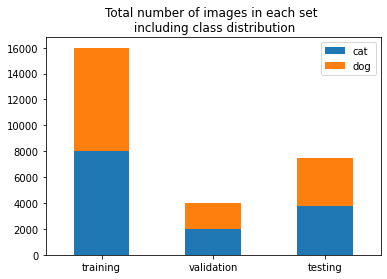

In [ ]:
num_training_cat = 0.8 * (len(os.listdir(train_cat_dir)) + len(os.listdir(train_dog_dir))) / 2
num_validation_cat = 0.2 * (len(os.listdir(train_cat_dir)) + len(os.listdir(train_dog_dir))) / 2 - 1
num_testing_cat = len(os.listdir(test_cat_dir)) + len(os.listdir(test_dog_dir)) / 2 

num_training_dog = 0.8 * (len(os.listdir(train_cat_dir)) + len(os.listdir(train_dog_dir))) / 2
num_validation_dog = 0.2 * (len(os.listdir(train_cat_dir)) + len(os.listdir(train_dog_dir))) / 2 - 1
num_testing_dog = len(os.listdir(test_cat_dir)) + len(os.listdir(test_dog_dir)) / 2 

totals_df = pd.DataFrame({
    'cat': [num_training_cat, num_validation_cat, num_testing_cat],
    'dog': [num_training_dog, num_validation_dog, num_testing_dog]
}, index=['training', 'validation', 'testing'])

ax = totals_df.plot(kind='bar', stacked=True, title="Total number of images in each set \n including class distribution")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

View a selection of images and their labels.

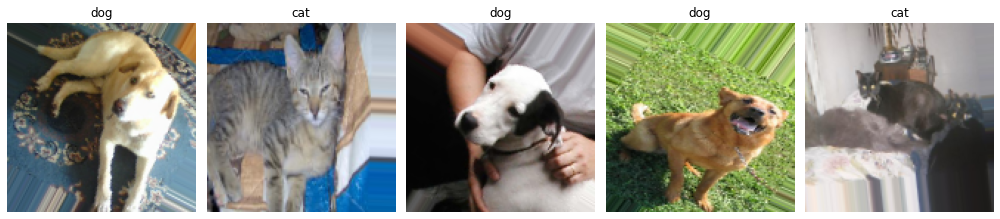

In [ ]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 5, figsize=(14,5))
    axes = axes.flatten()

    for img, label, ax in zip(images_arr, labels, axes):
        ax.imshow(img)
        ax.set_title(f"{'dog' if label == 1 else 'cat'}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

imgs, labels = next(train_ds)
plotImages(imgs, labels)

Validation images for comparison.

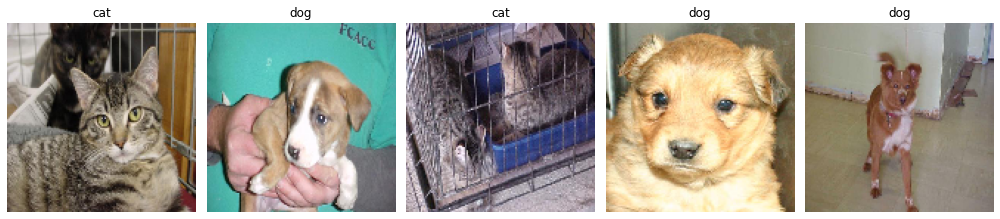

In [ ]:
imgs, labels = next(val_ds)
plotImages(imgs, labels)

# Experimentation


## Pre-existing deep learning algorithms

### Testing a selection of architectures

#### ResNet50

In [ ]:
# Get the ResNet50 model
ResNet50_model = tf.keras.applications.ResNet50(include_top=True, 
                                    weights=None, 
                                    input_shape=(128, 128, 3),
                                    classes=1,
                                    classifier_activation='sigmoid')

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
ResNet50_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Set up early stopping callback
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Train the model
ResNet50_history = ResNet50_model.fit(train_ds, epochs=100, validation_data=val_ds, 
                                      validation_steps=50, callbacks = [early_stopping_monitor])

Epoch 1/100
 85/625 [===>..........................] - ETA: 1:51 - loss: 0.9543 - accuracy: 0.5566

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

625/625 [==============================] - 146s 225ms/step - loss: 0.7230 - accuracy: 0.6066 - val_loss: 1.3261 - val_accuracy: 0.6000
Epoch 2/100
625/625 [==============================] - 138s 221ms/step - loss: 0.6412 - accuracy: 0.6482 - val_loss: 0.7289 - val_accuracy: 0.5400
Epoch 3/100
625/625 [==============================] - 139s 222ms/step - loss: 0.6154 - accuracy: 0.6651 - val_loss: 0.6481 - val_accuracy: 0.6281
Epoch 4/100
625/625 [==============================] - 141s 226ms/step - loss: 0.5791 - accuracy: 0.7038 - val_loss: 0.6377 - val_accuracy: 0.7006
Epoch 5/100
625/625 [==============================] - 138s 221ms/step - loss: 0.5612 - accuracy: 0.7181 - val_loss: 4.5110 - val_accuracy: 0.5194
Epoch 6/100
625/625 [==============================] - 138s 220ms/step - loss: 0.5218 - accuracy: 0.7423 - val_loss: 0.7157 - val_accuracy: 0.6544
Epoch 7/100
625/625 [==============================] - 138s 220ms/step - loss: 0.4813 - accuracy: 0.7678 - val_loss: 0.6994 - val_

#### VGG16

In [ ]:
# Get the VGG16 model
VGG16_model = tf.keras.applications.VGG16(include_top=True, 
                                    weights=None, 
                                    input_shape=(128, 128, 3),
                                    classes=1,
                                    classifier_activation='sigmoid')

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
VGG16_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Set up early stopping callback
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Train the model
VGG16_history = VGG16_model.fit(train_ds, epochs=100, validation_data=val_ds, 
                                validation_steps=50, callbacks = [early_stopping_monitor])

Epoch 1/100
357/625 [================>.............] - ETA: 55s - loss: 0.6880 - accuracy: 0.5359

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

625/625 [==============================] - 141s 222ms/step - loss: 0.6755 - accuracy: 0.5627 - val_loss: 0.6396 - val_accuracy: 0.6162
Epoch 2/100
625/625 [==============================] - 138s 221ms/step - loss: 0.6330 - accuracy: 0.6328 - val_loss: 0.5978 - val_accuracy: 0.6712
Epoch 3/100
625/625 [==============================] - 143s 229ms/step - loss: 0.6046 - accuracy: 0.6723 - val_loss: 0.5742 - val_accuracy: 0.7050
Epoch 4/100
625/625 [==============================] - 141s 225ms/step - loss: 0.5652 - accuracy: 0.7090 - val_loss: 0.5421 - val_accuracy: 0.7300
Epoch 5/100
625/625 [==============================] - 139s 222ms/step - loss: 0.5368 - accuracy: 0.7279 - val_loss: 0.5083 - val_accuracy: 0.7500
Epoch 6/100
625/625 [==============================] - 138s 221ms/step - loss: 0.5176 - accuracy: 0.7423 - val_loss: 0.5009 - val_accuracy: 0.7450
Epoch 7/100
625/625 [==============================] - 138s 221ms/step - loss: 0.4975 - accuracy: 0.7596 - val_loss: 0.5014 - val_

#### MobileNet

In [ ]:
# Get the MobileNet model
MobileNet_model = tf.keras.applications.MobileNet(include_top=True, 
                                    weights=None, 
                                    input_shape=(128, 128, 3),
                                    classes=1,
                                    classifier_activation='sigmoid')

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
MobileNet_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Set up early stopping callback
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Train the model
MobileNet_history = MobileNet_model.fit(train_ds, epochs=100, validation_data=val_ds, 
                                validation_steps=50, callbacks = [early_stopping_monitor])

Epoch 1/100
379/625 [=================>............] - ETA: 47s - loss: 0.6925 - accuracy: 0.5848

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

625/625 [==============================] - 135s 213ms/step - loss: 0.6778 - accuracy: 0.5978 - val_loss: 0.6903 - val_accuracy: 0.5075
Epoch 2/100
625/625 [==============================] - 131s 209ms/step - loss: 0.6310 - accuracy: 0.6374 - val_loss: 0.6442 - val_accuracy: 0.6269
Epoch 3/100
625/625 [==============================] - 131s 210ms/step - loss: 0.5988 - accuracy: 0.6765 - val_loss: 0.5996 - val_accuracy: 0.6781
Epoch 4/100
625/625 [==============================] - 131s 210ms/step - loss: 0.5528 - accuracy: 0.7152 - val_loss: 0.5318 - val_accuracy: 0.7369
Epoch 5/100
625/625 [==============================] - 131s 209ms/step - loss: 0.5249 - accuracy: 0.7380 - val_loss: 0.8288 - val_accuracy: 0.6569
Epoch 6/100
625/625 [==============================] - 131s 210ms/step - loss: 0.4868 - accuracy: 0.7641 - val_loss: 0.4811 - val_accuracy: 0.7694
Epoch 7/100
625/625 [==============================] - 131s 210ms/step - loss: 0.4539 - accuracy: 0.7807 - val_loss: 0.5284 - val_

#### Xception

In [ ]:
# Get the Xception model
Xception_model = tf.keras.applications.Xception(include_top=True, 
                                    weights=None, 
                                    input_shape=(128, 128, 3),
                                    classes=1,
                                    classifier_activation='sigmoid')

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
Xception_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Set up early stopping callback
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Train the model
Xception_history = Xception_model.fit(train_ds, epochs=100, validation_data=val_ds, 
                                validation_steps=50, callbacks = [early_stopping_monitor])

Epoch 1/100
396/500 [======================>.......] - ETA: 27s - loss: 0.6762 - accuracy: 0.6010

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 155s 278ms/step - loss: 0.6647 - accuracy: 0.6122 - val_loss: 0.6868 - val_accuracy: 0.5250
Epoch 2/100
500/500 [==============================] - 138s 275ms/step - loss: 0.5743 - accuracy: 0.7010 - val_loss: 1.4134 - val_accuracy: 0.5850
Epoch 3/100
500/500 [==============================] - 137s 275ms/step - loss: 0.4960 - accuracy: 0.7613 - val_loss: 0.5067 - val_accuracy: 0.7713
Epoch 4/100
500/500 [==============================] - 137s 273ms/step - loss: 0.4434 - accuracy: 0.7958 - val_loss: 0.3992 - val_accuracy: 0.8250
Epoch 5/100
500/500 [==============================] - 136s 272ms/step - loss: 0.4028 - accuracy: 0.8207 - val_loss: 0.6438 - val_accuracy: 0.6687
Epoch 6/100
500/500 [==============================] - 136s 272ms/step - loss: 0.3641 - accuracy: 0.8401 - val_loss: 0.3194 - val_accuracy: 0.8562
Epoch 7/100
500/500 [==============================] - 135s 271ms/step - loss: 0.3233 - accuracy: 0.8599 - val_loss: 0.4506 - val_

#### InceptionV3

In [ ]:
# Get the InceptionV3 model
InceptionV3_model = tf.keras.applications.InceptionV3(include_top=True, 
                                    weights=None, 
                                    input_shape=(128, 128, 3),
                                    classes=1,
                                    classifier_activation='sigmoid')

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
InceptionV3_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Set up early stopping callback
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Train the model
InceptionV3_history = InceptionV3_model.fit(train_ds, epochs=100, validation_data=val_ds, 
                                validation_steps=50, callbacks = [early_stopping_monitor])

Epoch 1/100
363/500 [====================>.........] - ETA: 33s - loss: 0.6928 - accuracy: 0.6018

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 136s 255ms/step - loss: 0.6843 - accuracy: 0.6060 - val_loss: 0.6883 - val_accuracy: 0.5938
Epoch 2/100
500/500 [==============================] - 128s 256ms/step - loss: 0.6368 - accuracy: 0.6414 - val_loss: 0.6358 - val_accuracy: 0.6869
Epoch 3/100
500/500 [==============================] - 126s 253ms/step - loss: 0.6035 - accuracy: 0.6757 - val_loss: 0.5723 - val_accuracy: 0.7138
Epoch 4/100
500/500 [==============================] - 128s 255ms/step - loss: 0.5795 - accuracy: 0.6958 - val_loss: 0.6786 - val_accuracy: 0.7000
Epoch 5/100
500/500 [==============================] - 129s 258ms/step - loss: 0.5556 - accuracy: 0.7194 - val_loss: 0.5699 - val_accuracy: 0.7212
Epoch 6/100
500/500 [==============================] - 127s 254ms/step - loss: 0.5362 - accuracy: 0.7298 - val_loss: 0.5808 - val_accuracy: 0.7506
Epoch 7/100
500/500 [==============================] - 127s 254ms/step - loss: 0.5146 - accuracy: 0.7448 - val_loss: 0.8330 - val_

### Optimising the algorithms


#### MobileNet

##### **Optimiser**

- **Aim:** Decide on the suitable optimizer to use with MobileNet. 
- **Method:** MobileNet model fitted with 3 different optimisers, save best each time and display best validation loss and validation accuracy to compare.
- **Parameters to be tuned:** optimiser of the MobileNet model; try SGD, Adam, and Adamax.

In [ ]:
optimisers = ["adam", "sgd", "adamax"]
mobilenet_opt_dict = {}

for opt in optimisers:
    
    print(f"------------ \n Fitting optimiser {opt} \n")

    # Get the MobileNet model
    MobileNet_model = tf.keras.applications.MobileNet(include_top=True, 
                                        weights=None, 
                                        input_shape=(128, 128, 3),
                                        classes=1,
                                        classifier_activation='sigmoid')

    # Compile the model
    MobileNet_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Set up callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=10)
    model_save = ModelCheckpoint(f'/content/drive/MyDrive/MobileNet_{opt}.hdf5', save_best_only=True)

    # Train the model
    history = MobileNet_model.fit(train_ds, epochs=500, 
                                  validation_data=val_ds,
                                  callbacks = [early_stopping_monitor, model_save])

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

    mobilenet_opt_dict[f"opt={str(opt)}"] = history.history
  
    # Save the dictionary as numpy file for future visualisations
    np.save(f'/content/drive/My Drive/mobilenet_opt_dict_{opt}', mobilenet_opt_dict)

# Save the dictionary as numpy file for future visualisations
np.save(f'/content/drive/My Drive/mobilenet_opt_dict', mobilenet_opt_dict)

------------ 
 Fitting optimiser adam 

Epoch 1/500
396/500 [======================>.......] - ETA: 19s - loss: 0.7031 - accuracy: 0.5747

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 122s 213ms/step - loss: 0.6929 - accuracy: 0.5844 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 2/500
500/500 [==============================] - 105s 209ms/step - loss: 0.6432 - accuracy: 0.6281 - val_loss: 0.7387 - val_accuracy: 0.6328
Epoch 3/500
500/500 [==============================] - 105s 210ms/step - loss: 0.6134 - accuracy: 0.6600 - val_loss: 0.6939 - val_accuracy: 0.5855
Epoch 4/500
500/500 [==============================] - 104s 209ms/step - loss: 0.5861 - accuracy: 0.6824 - val_loss: 0.7310 - val_accuracy: 0.6483
Epoch 5/500
500/500 [==============================] - 105s 209ms/step - loss: 0.5577 - accuracy: 0.7114 - val_loss: 0.7403 - val_accuracy: 0.6771
Epoch 6/500
500/500 [==============================] - 105s 209ms/step - loss: 0.5334 - accuracy: 0.7295 - val_loss: 0.4818 - val_accuracy: 0.7646
Epoch 7/500
500/500 [==============================] - 104s 207ms/step - loss: 0.5062 - accuracy: 0.7509 - val_loss: 0.6096 - val_

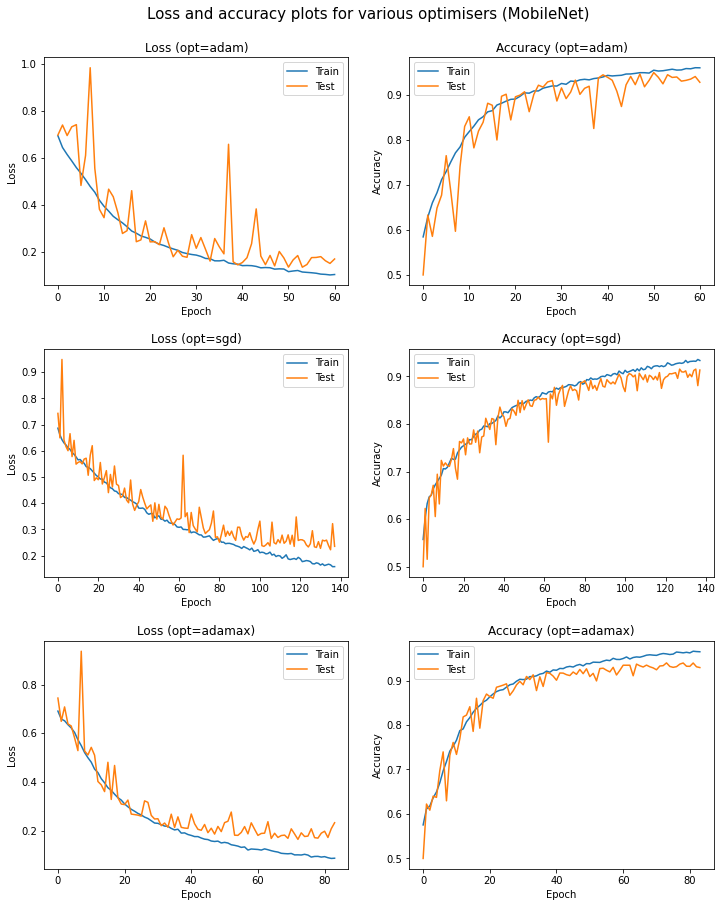

In [ ]:
# Plot loss and accuracy for each optimiser
(fig, axs) = plt.subplots(3, 2, figsize=(12,14))

plt.suptitle("Loss and accuracy plots for various optimisers (MobileNet)", fontsize=15)
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.28)

axs_it = iter(axs.ravel())

titles = ["adam", "sgd", "adamax"]

for (key, ax_title) in zip(mobilenet_opt_dict.keys(), titles): 
  # Plot loss
  cur_ax = next(axs_it)
  cur_ax.plot(mobilenet_opt_dict[key]['loss'])
  cur_ax.plot(mobilenet_opt_dict[key]['val_loss'])

  cur_ax.set_title(f"Loss (opt={ax_title})")
  cur_ax.set_ylabel('Loss')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])

  # Plot accuracy 
  cur_ax = next(axs_it)
  cur_ax.plot(mobilenet_opt_dict[key]['accuracy'])
  cur_ax.plot(mobilenet_opt_dict[key]['val_accuracy'])

  cur_ax.set_title(f"Accuracy (opt={ax_title})")
  cur_ax.set_ylabel('Accuracy')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])

As expected, SGD took much longer to train, and improved much less than the Adam optimiser. Adamax was comparable to Adam but offered no improvement in more epochs. Although tuning of the learning rate may help improve the SGD optimised model, I will go forward with the Adam optimiser.

##### **Learning rate**

- **Aim:** Find the best learning rate for MobileNet.
- **Method:** MobileNet model fitted with a selection of learning rates, save best each time and display best validation loss and validation accuracy to compare.
- **Parameters to be tuned:** learning rate.

Using 3 only to avoid fitting unnecessarily. If the performance at either highest or the lowest learning rate is significantly better to others, I will continue testing the next learning rate in that direction.


In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
learning_rate_names = ['01', '001', '0001']
mobilenet_lr_dict = {}

for lr, name in zip(learning_rates, learning_rate_names):
    
    print(f"------------ \n Fitting learning rate {lr} \n")

    # Get the MobileNet model
    MobileNet_model = tf.keras.applications.MobileNet(include_top=True, 
                                        weights=None, 
                                        input_shape=(128, 128, 3),
                                        classes=1,
                                        classifier_activation='sigmoid')
    
    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model
    MobileNet_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Set up callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=10)
    model_save = ModelCheckpoint(f'/content/drive/MyDrive/MobileNet_Adam_{name}.hdf5', save_best_only=True)

    # Train the model
    history = MobileNet_model.fit(train_ds, epochs=500, 
                                  validation_data=val_ds,
                                  callbacks = [early_stopping_monitor, model_save])

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

    mobilenet_lr_dict[f"lr={str(lr)}"] = history.history
  
    # Checkpoint save
    np.save(f'/content/drive/My Drive/mobilenet_lr_dict_{lr}', mobilenet_lr_dict)

# Save the dictionary as numpy file for future visualisations
np.save(f'/content/drive/My Drive/mobilenet_lr_dict', mobilenet_lr_dict)

------------ 
 Fitting learning rate 0.01 

Epoch 1/500
396/500 [======================>.......] - ETA: 19s - loss: 0.6987 - accuracy: 0.5850

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 119s 210ms/step - loss: 0.6889 - accuracy: 0.5918 - val_loss: 0.7321 - val_accuracy: 0.5185
Epoch 2/500
500/500 [==============================] - 101s 202ms/step - loss: 0.6308 - accuracy: 0.6459 - val_loss: 1.2136 - val_accuracy: 0.5708
Epoch 3/500
500/500 [==============================] - 102s 203ms/step - loss: 0.5875 - accuracy: 0.6884 - val_loss: 0.6210 - val_accuracy: 0.6761
Epoch 4/500
500/500 [==============================] - 102s 204ms/step - loss: 0.5549 - accuracy: 0.7166 - val_loss: 2.1710 - val_accuracy: 0.5480
Epoch 5/500
500/500 [==============================] - 101s 201ms/step - loss: 0.5171 - accuracy: 0.7454 - val_loss: 0.9533 - val_accuracy: 0.6246
Epoch 6/500
500/500 [==============================] - 102s 203ms/step - loss: 0.4972 - accuracy: 0.7572 - val_loss: 0.5076 - val_accuracy: 0.7774
Epoch 7/500
500/500 [==============================] - 101s 202ms/step - loss: 0.4606 - accuracy: 0.7824 - val_loss: 0.5738 - val_

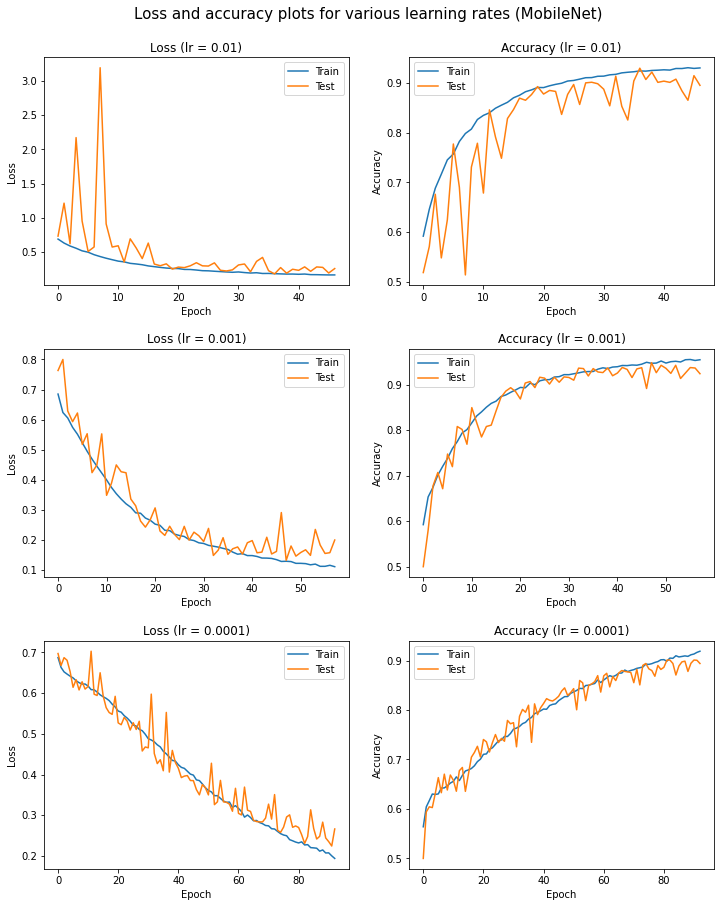

In [ ]:
# Plot loss and accuracy for each learning rate 
(fig, axs) = plt.subplots(3, 2, figsize=(12,14))

plt.suptitle("Loss and accuracy plots for various learning rates (MobileNet)", fontsize=15)
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.28)

axs_it = iter(axs.ravel())

titles = ["lr = 0.01", "lr = 0.001", "lr = 0.0001"]

for (key, ax_title) in zip(mobilenet_lr_dict.keys(), titles): 
  # Plot loss
  cur_ax = next(axs_it)
  cur_ax.plot(mobilenet_lr_dict[key]['loss'])
  cur_ax.plot(mobilenet_lr_dict[key]['val_loss'])

  cur_ax.set_title(f"Loss ({ax_title})")
  cur_ax.set_ylabel('Loss')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])

  # Plot accuracy 
  cur_ax = next(axs_it)
  cur_ax.plot(mobilenet_lr_dict[key]['accuracy'])
  cur_ax.plot(mobilenet_lr_dict[key]['val_accuracy'])

  cur_ax.set_title(f"Accuracy ({ax_title})")
  cur_ax.set_ylabel('Accuracy')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])

Learning rate of 0.001 performed best, offering highest validation accuracy. 

#### Xception

##### **Optimiser**

- **Aim:** Decide on the suitable optimizer to use with Xception. 
- **Method:** Xception model fitted with 3 different optimisers, save best each time and display best validation loss and validation accuracy to compare.
- **Parameters to be tuned:** optimiser of the Xception model; try SGD, Adam, and Adamax.

In [ ]:
optimisers = ["adam", "sgd", "adamax"]
xception_opt_dict = {}

for opt in optimisers:
    
    print(f"------------ \n Fitting optimiser {opt} \n")

    # Get the Xception model
    Xception_model = tf.keras.applications.Xception(include_top=True, 
                                        weights=None, 
                                        input_shape=(128, 128, 3),
                                        classes=1,
                                        classifier_activation='sigmoid')

    # Compile the model
    Xception_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Set up callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=10)
    model_save = ModelCheckpoint(f'/content/drive/MyDrive/Xception_{opt}.hdf5', save_best_only=True)

    # Train the model
    history = Xception_model.fit(train_ds, epochs=500, 
                                  validation_data=val_ds,
                                  callbacks = [early_stopping_monitor, model_save])

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

    xception_opt_dict[f"opt={str(opt)}"] = history.history
  
    # Save the dictionary as numpy file for future visualisations
    np.save(f'/content/drive/My Drive/xception_opt_dict_{opt}', xception_opt_dict)

# Save the dictionary as numpy file for future visualisations
np.save(f'/content/drive/My Drive/xception_opt_dict', xception_opt_dict)

------------ 
 Fitting optimiser adam 

Epoch 1/500
462/500 [==========================>...] - ETA: 7s - loss: 0.6437 - accuracy: 0.6398

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 116s 223ms/step - loss: 0.6393 - accuracy: 0.6441 - val_loss: 0.7028 - val_accuracy: 0.5075
Epoch 2/500
500/500 [==============================] - 109s 218ms/step - loss: 0.5455 - accuracy: 0.7291 - val_loss: 3.6124 - val_accuracy: 0.5050
Epoch 3/500
500/500 [==============================] - 111s 222ms/step - loss: 0.4881 - accuracy: 0.7673 - val_loss: 0.4556 - val_accuracy: 0.7969
Epoch 4/500
500/500 [==============================] - 109s 217ms/step - loss: 0.4406 - accuracy: 0.7938 - val_loss: 0.8568 - val_accuracy: 0.6601
Epoch 5/500
500/500 [==============================] - 112s 224ms/step - loss: 0.3938 - accuracy: 0.8207 - val_loss: 0.3990 - val_accuracy: 0.8134
Epoch 6/500
500/500 [==============================] - 109s 217ms/step - loss: 0.3508 - accuracy: 0.8442 - val_loss: 0.7140 - val_accuracy: 0.7639
Epoch 7/500
500/500 [==============================] - 108s 216ms/step - loss: 0.3109 - accuracy: 0.8622 - val_loss: 0.6659 - val_

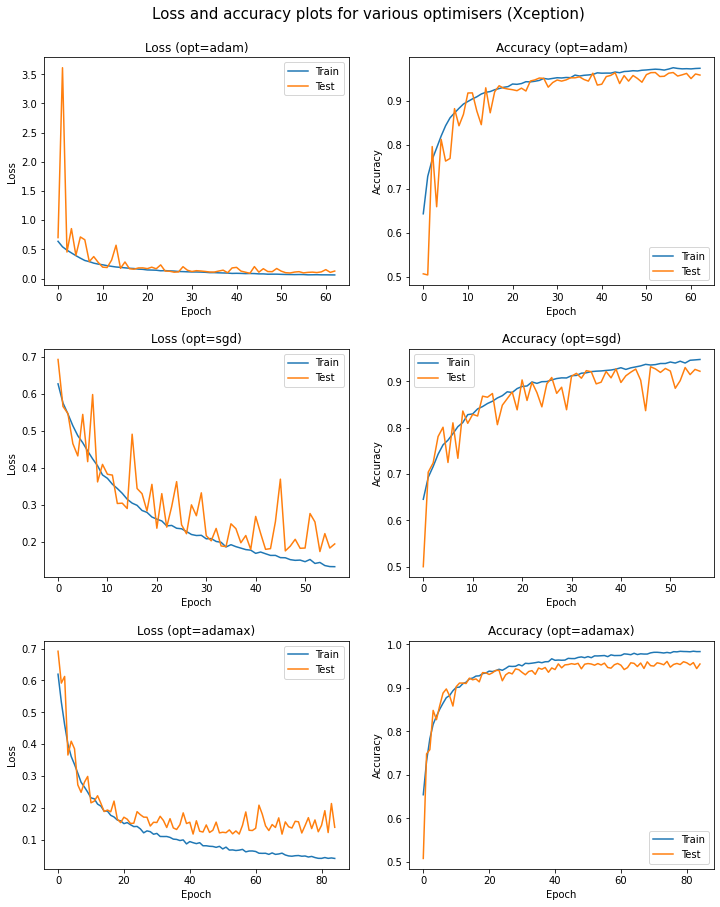

In [ ]:
# Plot loss and accuracy for each optimiser
(fig, axs) = plt.subplots(3, 2, figsize=(12,14))

plt.suptitle("Loss and accuracy plots for various optimisers (Xception)", fontsize=15)
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.28)

axs_it = iter(axs.ravel())

titles = ["adam", "sgd", "adamax"]

for (key, ax_title) in zip(xception_opt_dict.keys(), titles): 
  # Plot loss
  cur_ax = next(axs_it)
  cur_ax.plot(xception_opt_dict[key]['loss'])
  cur_ax.plot(xception_opt_dict[key]['val_loss'])

  cur_ax.set_title(f"Loss (opt={ax_title})")
  cur_ax.set_ylabel('Loss')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])

  # Plot accuracy 
  cur_ax = next(axs_it)
  cur_ax.plot(xception_opt_dict[key]['accuracy'])
  cur_ax.plot(xception_opt_dict[key]['val_accuracy'])

  cur_ax.set_title(f"Accuracy (opt={ax_title})")
  cur_ax.set_ylabel('Accuracy')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])


`Adam` optimizer achieved higher top accuracy in fewer epochs. The shape of the curve suggests that there is still room for improvement versus adamax which performed similarly but took more epochs to reach the early stopping threshold and the accuracy test curve seems to have plateaued.

##### **Learning rate**

- **Aim:** Decide on the suitable learning rate to use with Xception. 
- **Method:** Xception model fitted with 3 different learning rates, save best each time and display best validation loss and validation accuracy to compare.
- **Parameters to be tuned:** learning rate.

Using 3 only to avoid fitting unnecessarily. If the performance at either highest or the lowest learning rate is significantly better to others, I will continue testing the next learning rate in that direction.

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
learning_rate_names = ['01', '001', '0001']
xception_lr_dict = {}

for lr, name in zip(learning_rates, learning_rate_names):
    
    print(f"------------ \n Fitting learning rate {lr} \n")

    # Get the Xception model
    Xception_model = tf.keras.applications.Xception(include_top=True, 
                                        weights=None, 
                                        input_shape=(128, 128, 3),
                                        classes=1,
                                        classifier_activation='sigmoid')
    
    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model
    Xception_model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Set up callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=10)
    model_save = ModelCheckpoint(f'/content/drive/MyDrive/Xception_Adam_{name}.hdf5', save_best_only=True)

    # Train the model
    history = Xception_model.fit(train_ds, epochs=500, 
                                  validation_data=val_ds,
                                  callbacks = [early_stopping_monitor, model_save])

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

    xception_lr_dict[f"lr={str(lr)}"] = history.history
  
    # Checkpoint save
    np.save(f'/content/drive/My Drive/xception_lr_dict_{lr}', xception_lr_dict)

# Save the dictionary as numpy file for future visualisations
np.save(f'/content/drive/My Drive/xception_lr_dict', xception_lr_dict)

------------ 
 Fitting learning rate 0.01 

Epoch 1/500
 20/500 [>.............................] - ETA: 1:36 - loss: 1.7084 - accuracy: 0.4766

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 115s 221ms/step - loss: 0.7436 - accuracy: 0.5567 - val_loss: 0.6710 - val_accuracy: 0.5783
Epoch 2/500
500/500 [==============================] - 110s 220ms/step - loss: 0.6725 - accuracy: 0.5884 - val_loss: 1.0686 - val_accuracy: 0.5738
Epoch 3/500
500/500 [==============================] - 110s 221ms/step - loss: 0.6620 - accuracy: 0.6010 - val_loss: 0.6770 - val_accuracy: 0.5650
Epoch 4/500
500/500 [==============================] - 112s 224ms/step - loss: 0.6319 - accuracy: 0.6444 - val_loss: 0.6141 - val_accuracy: 0.6673
Epoch 5/500
500/500 [==============================] - 111s 221ms/step - loss: 0.5991 - accuracy: 0.6802 - val_loss: 0.7298 - val_accuracy: 0.6513
Epoch 6/500
500/500 [==============================] - 110s 220ms/step - loss: 0.5736 - accuracy: 0.7026 - val_loss: 0.6499 - val_accuracy: 0.6676
Epoch 7/500
500/500 [==============================] - 110s 219ms/step - loss: 0.5542 - accuracy: 0.7218 - val_loss: 0.6957 - val_

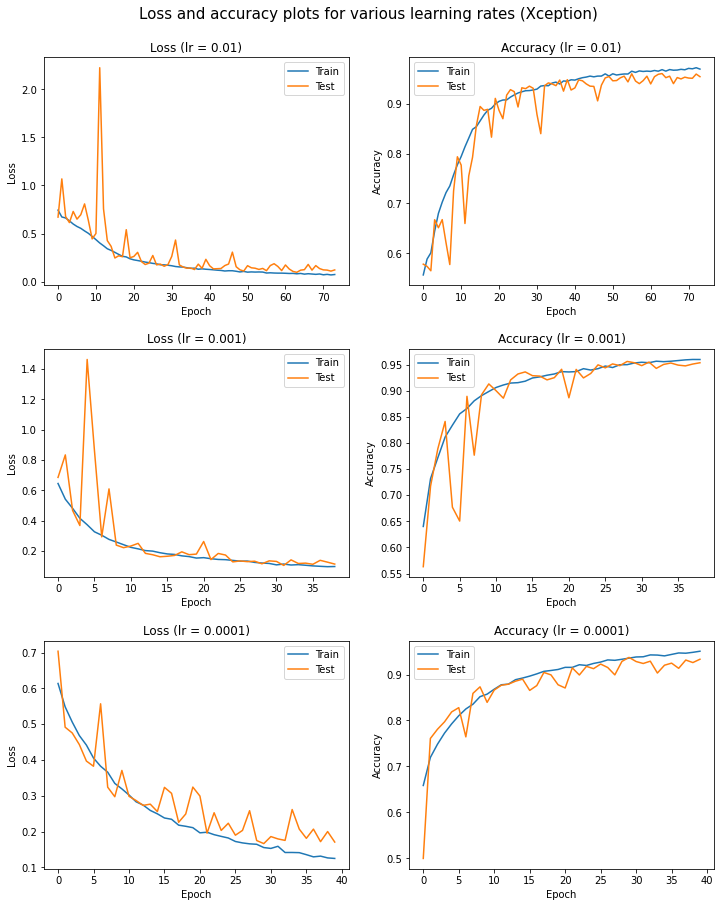

In [ ]:
# Plot loss and accuracy for each learning rate
(fig, axs) = plt.subplots(3, 2, figsize=(12,14))

plt.suptitle("Loss and accuracy plots for various learning rates (Xception)", fontsize=15)
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.28)

axs_it = iter(axs.ravel())

titles = ["lr = 0.01", "lr = 0.001", "lr = 0.0001"]

for (key, ax_title) in zip(xception_lr_dict.keys(), titles): 
  # Plot loss
  cur_ax = next(axs_it)
  cur_ax.plot(xception_lr_dict[key]['loss'])
  cur_ax.plot(xception_lr_dict[key]['val_loss'])

  cur_ax.set_title(f"Loss ({ax_title})")
  cur_ax.set_ylabel('Loss')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])

  # Plot accuracy 
  cur_ax = next(axs_it)
  cur_ax.plot(xception_lr_dict[key]['accuracy'])
  cur_ax.plot(xception_lr_dict[key]['val_accuracy'])

  cur_ax.set_title(f"Accuracy ({ax_title})")
  cur_ax.set_ylabel('Accuracy')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])


Although it took many epochs to get there, the 0.01 learning rate achieved the highest validation accuracy of the three rates tested. It is possible that 0.001 could match or exceed this learning rate given a larger early stopping patience parameter as in this particular instance it reached only 39 epochs. However, as the result of this particular experiment shows that 0.01 learning rate is superior, I will proceed with this value.

## Self-built network

### Building the network

#### Initial model

In [ ]:
# Instantiate the model
model = Sequential()

# First convolutional layer
model.add(Conv2D(filters=16, kernel_size=3, 
                 input_shape=(128, 128, 3), activation='relu'))

# Flatten the output
model.add(Flatten())

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Set up callbacks
#early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=10)
#model_save = ModelCheckpoint(f'/content/drive/MyDrive/Xception_{opt}.hdf5', save_best_only=True)

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds,
                    #callbacks = [early_stopping_monitor, model_save]
                    )

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
474/500 [===========================>..] - ETA: 4s - loss: 0.7587 - accuracy: 0.5876

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 105s 209ms/step - loss: 0.7534 - accuracy: 0.5890 - val_loss: 0.6162 - val_accuracy: 0.6698
Epoch 2/10
500/500 [==============================] - 104s 208ms/step - loss: 0.6496 - accuracy: 0.6357 - val_loss: 0.6126 - val_accuracy: 0.6878
Epoch 3/10
500/500 [==============================] - 102s 203ms/step - loss: 0.6432 - accuracy: 0.6376 - val_loss: 0.6337 - val_accuracy: 0.6471
Epoch 4/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6479 - accuracy: 0.6339 - val_loss: 0.5962 - val_accuracy: 0.6801
Epoch 5/10
500/500 [==============================] - 102s 203ms/step - loss: 0.6378 - accuracy: 0.6448 - val_loss: 0.6545 - val_accuracy: 0.6286
Epoch 6/10
500/500 [==============================] - 102s 203ms/step - loss: 0.6453 - accuracy: 0.6401 - val_loss: 0.6054 - val_accuracy: 0.6673
Epoch 7/10
500/500 [==============================] - 102s 203ms/step - loss: 0.6307 - accuracy: 0.6476 - val_loss: 0.5767 - val_accura

Add padding

In [ ]:
# Instantiate the model
model = Sequential()

# First convolutional layer
model.add(Conv2D(filters=16, kernel_size=3, 
                 input_shape=(128, 128, 3),
                 padding='same', 
                 activation='relu'))

# Flatten the output
model.add(Flatten())

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
 23/500 [>.............................] - ETA: 1:22 - loss: 3.0028 - accuracy: 0.4891

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 102s 204ms/step - loss: 0.7834 - accuracy: 0.5869 - val_loss: 0.6438 - val_accuracy: 0.6216
Epoch 2/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6463 - accuracy: 0.6323 - val_loss: 0.6159 - val_accuracy: 0.6801
Epoch 3/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6422 - accuracy: 0.6350 - val_loss: 0.6164 - val_accuracy: 0.6656
Epoch 4/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6407 - accuracy: 0.6397 - val_loss: 0.5975 - val_accuracy: 0.6828
Epoch 5/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6363 - accuracy: 0.6414 - val_loss: 0.5957 - val_accuracy: 0.6826
Epoch 6/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6378 - accuracy: 0.6416 - val_loss: 0.6180 - val_accuracy: 0.6726
Epoch 7/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6344 - accuracy: 0.6441 - val_loss: 0.6075 - val_accura

Double the filters

In [ ]:
# Instantiate the model
model = Sequential()

# First convolutional layer
model.add(Conv2D(filters=32, kernel_size=3, 
                 input_shape=(128, 128, 3),
                 padding='same', 
                 activation='relu'))

# Flatten the output
model.add(Flatten())

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
252/500 [==============>...............] - ETA: 44s - loss: 1.0523 - accuracy: 0.5510

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 102s 202ms/step - loss: 0.8602 - accuracy: 0.5734 - val_loss: 0.6408 - val_accuracy: 0.6443
Epoch 2/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6575 - accuracy: 0.6058 - val_loss: 0.6322 - val_accuracy: 0.6361
Epoch 3/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6515 - accuracy: 0.6158 - val_loss: 0.6449 - val_accuracy: 0.6286
Epoch 4/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6438 - accuracy: 0.6242 - val_loss: 0.6257 - val_accuracy: 0.6431
Epoch 5/10
500/500 [==============================] - 102s 203ms/step - loss: 0.6395 - accuracy: 0.6345 - val_loss: 0.6204 - val_accuracy: 0.6561
Epoch 6/10
500/500 [==============================] - 102s 203ms/step - loss: 0.6411 - accuracy: 0.6294 - val_loss: 0.6172 - val_accuracy: 0.6581
Epoch 7/10
500/500 [==============================] - 102s 203ms/step - loss: 0.6415 - accuracy: 0.6284 - val_loss: 0.6288 - val_accura

##### Add layer

Extra layer no padding

In [ ]:
# Instantiate the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
 21/500 [>.............................] - ETA: 1:23 - loss: 0.9708 - accuracy: 0.5000

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 103s 204ms/step - loss: 0.6708 - accuracy: 0.5978 - val_loss: 0.6138 - val_accuracy: 0.6726
Epoch 2/10
500/500 [==============================] - 102s 205ms/step - loss: 0.6343 - accuracy: 0.6395 - val_loss: 0.6026 - val_accuracy: 0.6708
Epoch 3/10
500/500 [==============================] - 102s 204ms/step - loss: 0.6201 - accuracy: 0.6594 - val_loss: 0.5621 - val_accuracy: 0.7099
Epoch 4/10
500/500 [==============================] - 102s 204ms/step - loss: 0.6123 - accuracy: 0.6642 - val_loss: 0.5566 - val_accuracy: 0.7139
Epoch 5/10
500/500 [==============================] - 102s 203ms/step - loss: 0.5928 - accuracy: 0.6794 - val_loss: 0.5560 - val_accuracy: 0.7101
Epoch 6/10
500/500 [==============================] - 102s 205ms/step - loss: 0.5872 - accuracy: 0.6861 - val_loss: 0.5470 - val_accuracy: 0.7234
Epoch 7/10
500/500 [==============================] - 102s 204ms/step - loss: 0.5823 - accuracy: 0.6868 - val_loss: 0.5338 - val_accura

Extra layer with padding



In [ ]:
# Instantiate the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
203/500 [===========>..................] - ETA: 53s - loss: 0.8090 - accuracy: 0.5214

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 102s 202ms/step - loss: 0.7307 - accuracy: 0.5414 - val_loss: 0.6563 - val_accuracy: 0.6036
Epoch 2/10
500/500 [==============================] - 101s 201ms/step - loss: 0.6713 - accuracy: 0.5646 - val_loss: 0.6548 - val_accuracy: 0.5900
Epoch 3/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6658 - accuracy: 0.5802 - val_loss: 0.6558 - val_accuracy: 0.6103
Epoch 4/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6554 - accuracy: 0.6036 - val_loss: 0.6438 - val_accuracy: 0.6428
Epoch 5/10
500/500 [==============================] - 101s 201ms/step - loss: 0.6514 - accuracy: 0.6141 - val_loss: 0.6290 - val_accuracy: 0.6496
Epoch 6/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6386 - accuracy: 0.6332 - val_loss: 0.5902 - val_accuracy: 0.6901
Epoch 7/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6297 - accuracy: 0.6411 - val_loss: 0.5967 - val_accura

##### Pooling

Pooling - first layer only

In [ ]:
# Instantiate the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
204/500 [===========>..................] - ETA: 53s - loss: 0.6848 - accuracy: 0.5556

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 101s 201ms/step - loss: 0.6734 - accuracy: 0.5854 - val_loss: 0.6297 - val_accuracy: 0.6733
Epoch 2/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6424 - accuracy: 0.6340 - val_loss: 0.5874 - val_accuracy: 0.6966
Epoch 3/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6200 - accuracy: 0.6594 - val_loss: 0.5662 - val_accuracy: 0.7194
Epoch 4/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6067 - accuracy: 0.6681 - val_loss: 0.5746 - val_accuracy: 0.7056
Epoch 5/10
500/500 [==============================] - 100s 201ms/step - loss: 0.5937 - accuracy: 0.6874 - val_loss: 0.5498 - val_accuracy: 0.7261
Epoch 6/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5803 - accuracy: 0.6977 - val_loss: 0.5185 - val_accuracy: 0.7489
Epoch 7/10
500/500 [==============================] - 100s 201ms/step - loss: 0.5781 - accuracy: 0.6977 - val_loss: 0.5437 - val_accura

Pooling - both layers

In [ ]:
# Instantiate the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
372/500 [=====================>........] - ETA: 23s - loss: 0.6848 - accuracy: 0.5532

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 200ms/step - loss: 0.6789 - accuracy: 0.5664 - val_loss: 0.6545 - val_accuracy: 0.5845
Epoch 2/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6316 - accuracy: 0.6482 - val_loss: 0.5800 - val_accuracy: 0.6996
Epoch 3/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6041 - accuracy: 0.6736 - val_loss: 0.5638 - val_accuracy: 0.7041
Epoch 4/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5773 - accuracy: 0.6936 - val_loss: 0.5513 - val_accuracy: 0.7176
Epoch 5/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5636 - accuracy: 0.7054 - val_loss: 0.5082 - val_accuracy: 0.7479
Epoch 6/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5551 - accuracy: 0.7176 - val_loss: 0.5042 - val_accuracy: 0.7509
Epoch 7/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5528 - accuracy: 0.7176 - val_loss: 0.4902 - val_accura

Pooling - no padding

In [ ]:
# Instantiate the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
229/500 [============>.................] - ETA: 48s - loss: 0.6761 - accuracy: 0.5630

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 200ms/step - loss: 0.6551 - accuracy: 0.6036 - val_loss: 0.5891 - val_accuracy: 0.7006
Epoch 2/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6043 - accuracy: 0.6673 - val_loss: 0.5293 - val_accuracy: 0.7431
Epoch 3/10
500/500 [==============================] - 102s 203ms/step - loss: 0.5878 - accuracy: 0.6856 - val_loss: 0.5389 - val_accuracy: 0.7274
Epoch 4/10
500/500 [==============================] - 102s 203ms/step - loss: 0.5698 - accuracy: 0.7047 - val_loss: 0.5179 - val_accuracy: 0.7571
Epoch 5/10
500/500 [==============================] - 102s 203ms/step - loss: 0.5537 - accuracy: 0.7177 - val_loss: 0.5029 - val_accuracy: 0.7531
Epoch 6/10
500/500 [==============================] - 102s 204ms/step - loss: 0.5511 - accuracy: 0.7163 - val_loss: 0.5271 - val_accuracy: 0.7526
Epoch 7/10
500/500 [==============================] - 102s 204ms/step - loss: 0.5475 - accuracy: 0.7188 - val_loss: 0.4960 - val_accura

Although padding seemed to reduce performance before, it actually increases it slightly in a more complex model with pooling implemented. I will proceed with padding applied.

##### Dropout

Dropout 20% before pooling

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(2))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
171/500 [=========>....................] - ETA: 1:00 - loss: 0.6911 - accuracy: 0.5428

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 102s 203ms/step - loss: 0.6674 - accuracy: 0.5929 - val_loss: 0.6326 - val_accuracy: 0.6821
Epoch 2/10
500/500 [==============================] - 101s 201ms/step - loss: 0.6286 - accuracy: 0.6505 - val_loss: 0.5849 - val_accuracy: 0.6921
Epoch 3/10
500/500 [==============================] - 100s 201ms/step - loss: 0.6098 - accuracy: 0.6704 - val_loss: 0.5597 - val_accuracy: 0.7339
Epoch 4/10
500/500 [==============================] - 101s 202ms/step - loss: 0.5902 - accuracy: 0.6923 - val_loss: 0.5351 - val_accuracy: 0.7436
Epoch 5/10
500/500 [==============================] - 100s 201ms/step - loss: 0.5836 - accuracy: 0.6923 - val_loss: 0.5277 - val_accuracy: 0.7539
Epoch 6/10
500/500 [==============================] - 100s 201ms/step - loss: 0.5705 - accuracy: 0.7086 - val_loss: 0.5178 - val_accuracy: 0.7619
Epoch 7/10
500/500 [==============================] - 102s 204ms/step - loss: 0.5649 - accuracy: 0.7110 - val_loss: 0.5144 - val_accura

Dropout 20% after pooling

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
429/500 [========================>.....] - ETA: 12s - loss: 0.6858 - accuracy: 0.5632

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 98s 196ms/step - loss: 0.6817 - accuracy: 0.5692 - val_loss: 0.6343 - val_accuracy: 0.6663
Epoch 2/10
500/500 [==============================] - 98s 196ms/step - loss: 0.6373 - accuracy: 0.6354 - val_loss: 0.6099 - val_accuracy: 0.6973
Epoch 3/10
500/500 [==============================] - 98s 195ms/step - loss: 0.6158 - accuracy: 0.6621 - val_loss: 0.5728 - val_accuracy: 0.7029
Epoch 4/10
500/500 [==============================] - 98s 196ms/step - loss: 0.6031 - accuracy: 0.6732 - val_loss: 0.5638 - val_accuracy: 0.7189
Epoch 5/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5916 - accuracy: 0.6829 - val_loss: 0.5355 - val_accuracy: 0.7399
Epoch 6/10
500/500 [==============================] - 98s 195ms/step - loss: 0.5798 - accuracy: 0.6954 - val_loss: 0.5252 - val_accuracy: 0.7364
Epoch 7/10
500/500 [==============================] - 97s 194ms/step - loss: 0.5724 - accuracy: 0.7004 - val_loss: 0.5185 - val_accuracy: 0.7

Although the best validation accuracy is found when dropout happens before pooling, the second option results in lowest validation accuracy and is consistently quicker per epoch.

Dropout 20% not the final convolutional layer

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
111/500 [=====>........................] - ETA: 1:09 - loss: 0.6973 - accuracy: 0.5282

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 101s 200ms/step - loss: 0.6793 - accuracy: 0.5720 - val_loss: 0.6283 - val_accuracy: 0.6748
Epoch 2/10
500/500 [==============================] - 98s 195ms/step - loss: 0.6399 - accuracy: 0.6434 - val_loss: 0.5804 - val_accuracy: 0.7189
Epoch 3/10
500/500 [==============================] - 97s 194ms/step - loss: 0.6038 - accuracy: 0.6771 - val_loss: 0.5652 - val_accuracy: 0.7199
Epoch 4/10
500/500 [==============================] - 98s 195ms/step - loss: 0.5917 - accuracy: 0.6864 - val_loss: 0.5524 - val_accuracy: 0.7351
Epoch 5/10
500/500 [==============================] - 97s 194ms/step - loss: 0.5782 - accuracy: 0.7017 - val_loss: 0.5319 - val_accuracy: 0.7489
Epoch 6/10
500/500 [==============================] - 97s 195ms/step - loss: 0.5681 - accuracy: 0.7056 - val_loss: 0.5121 - val_accuracy: 0.7601
Epoch 7/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5599 - accuracy: 0.7149 - val_loss: 0.5001 - val_accuracy: 0.

Dropout 15%

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.15))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
460/500 [==========================>...] - ETA: 7s - loss: 0.6683 - accuracy: 0.5903

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 99s 196ms/step - loss: 0.6664 - accuracy: 0.5926 - val_loss: 0.5989 - val_accuracy: 0.6983
Epoch 2/10
500/500 [==============================] - 98s 195ms/step - loss: 0.6190 - accuracy: 0.6630 - val_loss: 0.5698 - val_accuracy: 0.7121
Epoch 3/10
500/500 [==============================] - 97s 195ms/step - loss: 0.6028 - accuracy: 0.6784 - val_loss: 0.5687 - val_accuracy: 0.6983
Epoch 4/10
500/500 [==============================] - 97s 195ms/step - loss: 0.5892 - accuracy: 0.6886 - val_loss: 0.5288 - val_accuracy: 0.7484
Epoch 5/10
500/500 [==============================] - 97s 195ms/step - loss: 0.5801 - accuracy: 0.6971 - val_loss: 0.5384 - val_accuracy: 0.7394
Epoch 6/10
500/500 [==============================] - 97s 194ms/step - loss: 0.5658 - accuracy: 0.7054 - val_loss: 0.5122 - val_accuracy: 0.7591
Epoch 7/10
500/500 [==============================] - 98s 195ms/step - loss: 0.5581 - accuracy: 0.7131 - val_loss: 0.5086 - val_accuracy: 0.7

Dropout 15% not the final layer

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.15))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
 43/500 [=>............................] - ETA: 1:21 - loss: 0.7268 - accuracy: 0.5109

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 98s 195ms/step - loss: 0.6820 - accuracy: 0.5779 - val_loss: 0.6334 - val_accuracy: 0.6573
Epoch 2/10
500/500 [==============================] - 97s 194ms/step - loss: 0.6420 - accuracy: 0.6334 - val_loss: 0.5928 - val_accuracy: 0.6911
Epoch 3/10
500/500 [==============================] - 97s 195ms/step - loss: 0.6135 - accuracy: 0.6664 - val_loss: 0.5686 - val_accuracy: 0.7191
Epoch 4/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5908 - accuracy: 0.6893 - val_loss: 0.5358 - val_accuracy: 0.7331
Epoch 5/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5795 - accuracy: 0.6950 - val_loss: 0.5377 - val_accuracy: 0.7379
Epoch 6/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5667 - accuracy: 0.7040 - val_loss: 0.5139 - val_accuracy: 0.7396
Epoch 7/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5597 - accuracy: 0.7112 - val_loss: 0.5025 - val_accuracy: 0.7

Dropout 25%

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
150/500 [========>.....................] - ETA: 1:02 - loss: 0.6928 - accuracy: 0.5337

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 101s 202ms/step - loss: 0.6736 - accuracy: 0.5724 - val_loss: 0.6274 - val_accuracy: 0.6573
Epoch 2/10
500/500 [==============================] - 100s 199ms/step - loss: 0.6347 - accuracy: 0.6402 - val_loss: 0.5928 - val_accuracy: 0.6868
Epoch 3/10
500/500 [==============================] - 99s 198ms/step - loss: 0.6239 - accuracy: 0.6504 - val_loss: 0.5931 - val_accuracy: 0.6948
Epoch 4/10
500/500 [==============================] - 99s 198ms/step - loss: 0.6060 - accuracy: 0.6662 - val_loss: 0.5661 - val_accuracy: 0.7266
Epoch 5/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5900 - accuracy: 0.6804 - val_loss: 0.5315 - val_accuracy: 0.7504
Epoch 6/10
500/500 [==============================] - 99s 199ms/step - loss: 0.5817 - accuracy: 0.6885 - val_loss: 0.5165 - val_accuracy: 0.7496
Epoch 7/10
500/500 [==============================] - 100s 199ms/step - loss: 0.5703 - accuracy: 0.7004 - val_loss: 0.5062 - val_accuracy: 

Dropout 25% not the final layer

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
214/500 [===========>..................] - ETA: 50s - loss: 0.6750 - accuracy: 0.5743

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 198ms/step - loss: 0.6572 - accuracy: 0.6064 - val_loss: 0.6026 - val_accuracy: 0.6836
Epoch 2/10
500/500 [==============================] - 99s 198ms/step - loss: 0.6298 - accuracy: 0.6474 - val_loss: 0.5884 - val_accuracy: 0.6818
Epoch 3/10
500/500 [==============================] - 99s 199ms/step - loss: 0.6145 - accuracy: 0.6675 - val_loss: 0.5613 - val_accuracy: 0.7251
Epoch 4/10
500/500 [==============================] - 99s 199ms/step - loss: 0.5978 - accuracy: 0.6757 - val_loss: 0.5464 - val_accuracy: 0.7241
Epoch 5/10
500/500 [==============================] - 99s 199ms/step - loss: 0.5802 - accuracy: 0.6935 - val_loss: 0.5370 - val_accuracy: 0.7196
Epoch 6/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5678 - accuracy: 0.7018 - val_loss: 0.5130 - val_accuracy: 0.7526
Epoch 7/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5613 - accuracy: 0.7093 - val_loss: 0.5159 - val_accuracy: 0.

Dropout 30%

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
 84/500 [====>.........................] - ETA: 1:15 - loss: 0.6866 - accuracy: 0.5331

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 101s 200ms/step - loss: 0.6645 - accuracy: 0.5799 - val_loss: 0.6300 - val_accuracy: 0.6223
Epoch 2/10
500/500 [==============================] - 98s 196ms/step - loss: 0.6317 - accuracy: 0.6377 - val_loss: 0.5854 - val_accuracy: 0.7041
Epoch 3/10
500/500 [==============================] - 99s 197ms/step - loss: 0.6060 - accuracy: 0.6664 - val_loss: 0.5517 - val_accuracy: 0.7254
Epoch 4/10
500/500 [==============================] - 99s 199ms/step - loss: 0.5893 - accuracy: 0.6817 - val_loss: 0.5302 - val_accuracy: 0.7509
Epoch 5/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5819 - accuracy: 0.6922 - val_loss: 0.5275 - val_accuracy: 0.7509
Epoch 6/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5694 - accuracy: 0.7000 - val_loss: 0.5189 - val_accuracy: 0.7546
Epoch 7/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5622 - accuracy: 0.7062 - val_loss: 0.5088 - val_accuracy: 0.

Dropout 30% not the final layer

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
365/500 [====================>.........] - ETA: 23s - loss: 0.6928 - accuracy: 0.5281

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 99s 197ms/step - loss: 0.6841 - accuracy: 0.5447 - val_loss: 0.6429 - val_accuracy: 0.6526
Epoch 2/10
500/500 [==============================] - 99s 197ms/step - loss: 0.6414 - accuracy: 0.6333 - val_loss: 0.6048 - val_accuracy: 0.6806
Epoch 3/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6189 - accuracy: 0.6596 - val_loss: 0.6011 - val_accuracy: 0.6903
Epoch 4/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5986 - accuracy: 0.6740 - val_loss: 0.5382 - val_accuracy: 0.7284
Epoch 5/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5826 - accuracy: 0.6942 - val_loss: 0.5461 - val_accuracy: 0.7429
Epoch 6/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5696 - accuracy: 0.7067 - val_loss: 0.5185 - val_accuracy: 0.7524
Epoch 7/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5671 - accuracy: 0.7111 - val_loss: 0.5023 - val_accuracy: 0.7

Dropout 40%

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
139/500 [=======>......................] - ETA: 1:04 - loss: 0.6979 - accuracy: 0.5218

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 200ms/step - loss: 0.6707 - accuracy: 0.5766 - val_loss: 0.6191 - val_accuracy: 0.6798
Epoch 2/10
500/500 [==============================] - 100s 199ms/step - loss: 0.6316 - accuracy: 0.6454 - val_loss: 0.5979 - val_accuracy: 0.6923
Epoch 3/10
500/500 [==============================] - 99s 199ms/step - loss: 0.6190 - accuracy: 0.6572 - val_loss: 0.5797 - val_accuracy: 0.6946
Epoch 4/10
500/500 [==============================] - 99s 199ms/step - loss: 0.6082 - accuracy: 0.6695 - val_loss: 0.5592 - val_accuracy: 0.7286
Epoch 5/10
500/500 [==============================] - 100s 199ms/step - loss: 0.5947 - accuracy: 0.6859 - val_loss: 0.5425 - val_accuracy: 0.7284
Epoch 6/10
500/500 [==============================] - 100s 199ms/step - loss: 0.5870 - accuracy: 0.6897 - val_loss: 0.5218 - val_accuracy: 0.7474
Epoch 7/10
500/500 [==============================] - 99s 199ms/step - loss: 0.5808 - accuracy: 0.6883 - val_loss: 0.5431 - val_accuracy:

Dropout 40% first layer only

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
403/500 [=======================>......] - ETA: 17s - loss: 0.6693 - accuracy: 0.5785

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 99s 197ms/step - loss: 0.6662 - accuracy: 0.5870 - val_loss: 0.6410 - val_accuracy: 0.6221
Epoch 2/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6331 - accuracy: 0.6421 - val_loss: 0.6073 - val_accuracy: 0.6796
Epoch 3/10
500/500 [==============================] - 99s 197ms/step - loss: 0.6130 - accuracy: 0.6629 - val_loss: 0.5655 - val_accuracy: 0.7184
Epoch 4/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5923 - accuracy: 0.6816 - val_loss: 0.5490 - val_accuracy: 0.7241
Epoch 5/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5823 - accuracy: 0.6918 - val_loss: 0.5363 - val_accuracy: 0.7331
Epoch 6/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5759 - accuracy: 0.6933 - val_loss: 0.5410 - val_accuracy: 0.7361
Epoch 7/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5702 - accuracy: 0.7003 - val_loss: 0.5329 - val_accuracy: 0.7

Overall, these experiments suggest the following:

- Lower validation loss and faster training times with dropout layers placed after pooling layers, although validation accuracy is higher (0.7624 vs 0.7551 after 10 epochs).
- Dropout of approximately 25% seems optimal based on validation accuracy:
  - 15% - 0.7656
  - 20% - 0.7551
  - 25% - 0.7764
  - 30% - 0.7691
  - 40% - 0.7473
- Not including dropout just before the final layer seems to achieve higher results in a slight majority of cases tested (starred below). Considering that the differences are minute and the experiments last for 10 epochs each only, this may be a random effect.
  - 15% - 0.7656 with and 0.7609 without
  - 20% - 0.7551 with and 0.7676 without*
  - 25% - 0.7764 with and 0.7773 without*
  - 30% - 0.7691 with and 0.7684 without
  - 40% - 0.7473 with and 0.7604 without*

##### Batch normalization

Batch normalization 1 layer - no dropout

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
275/500 [===============>..............] - ETA: 40s - loss: 0.6849 - accuracy: 0.6090

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 200ms/step - loss: 0.6655 - accuracy: 0.6242 - val_loss: 0.7122 - val_accuracy: 0.5765
Epoch 2/10
500/500 [==============================] - 100s 199ms/step - loss: 0.6076 - accuracy: 0.6667 - val_loss: 0.6077 - val_accuracy: 0.6881
Epoch 3/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5936 - accuracy: 0.6802 - val_loss: 0.5884 - val_accuracy: 0.7059
Epoch 4/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5805 - accuracy: 0.6981 - val_loss: 0.5433 - val_accuracy: 0.7341
Epoch 5/10
500/500 [==============================] - 99s 199ms/step - loss: 0.5712 - accuracy: 0.7039 - val_loss: 0.5654 - val_accuracy: 0.7274
Epoch 6/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5685 - accuracy: 0.7044 - val_loss: 0.6981 - val_accuracy: 0.6508
Epoch 7/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5691 - accuracy: 0.7035 - val_loss: 0.5925 - val_accurac

Batch normalization 1 layer with dropout

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
107/500 [=====>........................] - ETA: 1:10 - loss: 0.9534 - accuracy: 0.5461

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 101s 202ms/step - loss: 0.7312 - accuracy: 0.5873 - val_loss: 0.6601 - val_accuracy: 0.5548
Epoch 2/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6358 - accuracy: 0.6394 - val_loss: 0.6762 - val_accuracy: 0.5690
Epoch 3/10
500/500 [==============================] - 100s 201ms/step - loss: 0.6190 - accuracy: 0.6573 - val_loss: 0.7238 - val_accuracy: 0.5865
Epoch 4/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6139 - accuracy: 0.6662 - val_loss: 0.5832 - val_accuracy: 0.6973
Epoch 5/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5932 - accuracy: 0.6797 - val_loss: 0.5930 - val_accuracy: 0.6951
Epoch 6/10
500/500 [==============================] - 100s 199ms/step - loss: 0.5882 - accuracy: 0.6864 - val_loss: 0.6261 - val_accuracy: 0.6791
Epoch 7/10
500/500 [==============================] - 100s 201ms/step - loss: 0.5743 - accuracy: 0.6973 - val_loss: 0.5542 - val_accura

Batch normalization one layer & both dropout

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
 43/500 [=>............................] - ETA: 1:23 - loss: 1.3092 - accuracy: 0.5327

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 102s 202ms/step - loss: 0.7652 - accuracy: 0.5788 - val_loss: 0.6499 - val_accuracy: 0.5940
Epoch 2/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6465 - accuracy: 0.6249 - val_loss: 0.6235 - val_accuracy: 0.6433
Epoch 3/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6317 - accuracy: 0.6454 - val_loss: 0.6351 - val_accuracy: 0.6133
Epoch 4/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6174 - accuracy: 0.6631 - val_loss: 0.5967 - val_accuracy: 0.6788
Epoch 5/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6080 - accuracy: 0.6726 - val_loss: 0.5719 - val_accuracy: 0.7089
Epoch 6/10
500/500 [==============================] - 100s 201ms/step - loss: 0.6003 - accuracy: 0.6739 - val_loss: 0.5662 - val_accuracy: 0.7171
Epoch 7/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5946 - accuracy: 0.6799 - val_loss: 0.5594 - val_accura

Batch normalization both layers - no dropout

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
380/500 [=====================>........] - ETA: 21s - loss: 0.8606 - accuracy: 0.6003

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 101s 202ms/step - loss: 0.8397 - accuracy: 0.6023 - val_loss: 0.6561 - val_accuracy: 0.6486
Epoch 2/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6788 - accuracy: 0.6413 - val_loss: 0.6208 - val_accuracy: 0.6926
Epoch 3/10
500/500 [==============================] - 100s 199ms/step - loss: 0.6284 - accuracy: 0.6625 - val_loss: 0.6948 - val_accuracy: 0.6748
Epoch 4/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6149 - accuracy: 0.6752 - val_loss: 0.7463 - val_accuracy: 0.6513
Epoch 5/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5952 - accuracy: 0.6857 - val_loss: 0.5517 - val_accuracy: 0.7321
Epoch 6/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5865 - accuracy: 0.6939 - val_loss: 0.5643 - val_accuracy: 0.7191
Epoch 7/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5697 - accuracy: 0.7011 - val_loss: 0.6030 - val_accura

Batch normalization both layers with dropout

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
368/500 [=====================>........] - ETA: 23s - loss: 0.9119 - accuracy: 0.5726

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 101s 201ms/step - loss: 0.8868 - accuracy: 0.5741 - val_loss: 0.7327 - val_accuracy: 0.5673
Epoch 2/10
500/500 [==============================] - 100s 201ms/step - loss: 0.7119 - accuracy: 0.6198 - val_loss: 0.6449 - val_accuracy: 0.6526
Epoch 3/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6582 - accuracy: 0.6428 - val_loss: 0.5590 - val_accuracy: 0.7191
Epoch 4/10
500/500 [==============================] - 100s 201ms/step - loss: 0.6193 - accuracy: 0.6675 - val_loss: 0.5496 - val_accuracy: 0.7286
Epoch 5/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5978 - accuracy: 0.6826 - val_loss: 0.5394 - val_accuracy: 0.7306
Epoch 6/10
500/500 [==============================] - 100s 201ms/step - loss: 0.5965 - accuracy: 0.6815 - val_loss: 0.5403 - val_accuracy: 0.7389
Epoch 7/10
500/500 [==============================] - 100s 199ms/step - loss: 0.5860 - accuracy: 0.6918 - val_loss: 0.6010 - val_accura

Batch normalization both layers with 2 dropout

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                 padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
436/500 [=========================>....] - ETA: 11s - loss: 0.9512 - accuracy: 0.5768

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 99s 197ms/step - loss: 0.9491 - accuracy: 0.5763 - val_loss: 0.7389 - val_accuracy: 0.6033
Epoch 2/10
500/500 [==============================] - 99s 197ms/step - loss: 0.7813 - accuracy: 0.6067 - val_loss: 0.7055 - val_accuracy: 0.6426
Epoch 3/10
500/500 [==============================] - 99s 198ms/step - loss: 0.6771 - accuracy: 0.6326 - val_loss: 0.7866 - val_accuracy: 0.6056
Epoch 4/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6378 - accuracy: 0.6520 - val_loss: 0.5990 - val_accuracy: 0.6808
Epoch 5/10
500/500 [==============================] - 99s 197ms/step - loss: 0.6071 - accuracy: 0.6759 - val_loss: 0.5246 - val_accuracy: 0.7439
Epoch 6/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5888 - accuracy: 0.6858 - val_loss: 0.5678 - val_accuracy: 0.7184
Epoch 7/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5838 - accuracy: 0.6900 - val_loss: 0.5336 - val_accuracy: 0.7

Batch normalisation seems to offer lower results compared to the best dropout only architecture. I will proceed without this type of layer for now, and may revisit it later.

#### Adding depth & complexity
Based on the best model so far, I will tweak the architecture to increase complexity, aiming to achieve higher performance.

##### More layers

In [ ]:
hidden_conv_layers = [1, 2, 3, 4, 5, 6]

for number in hidden_conv_layers:
    
    print(f"------------ \n Fitting with {number} hidden conv layer(s) \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    for i in range(number):
        model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 1 hidden conv layer(s) 

Epoch 1/10
265/500 [==============>...............] - ETA: 41s - loss: 0.6842 - accuracy: 0.5517

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 99s 197ms/step - loss: 0.6702 - accuracy: 0.5832 - val_loss: 0.6213 - val_accuracy: 0.6888
Epoch 2/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6292 - accuracy: 0.6438 - val_loss: 0.5808 - val_accuracy: 0.7091
Epoch 3/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6126 - accuracy: 0.6639 - val_loss: 0.5704 - val_accuracy: 0.7239
Epoch 4/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5946 - accuracy: 0.6777 - val_loss: 0.5568 - val_accuracy: 0.7116
Epoch 5/10
500/500 [==============================] - 102s 204ms/step - loss: 0.5816 - accuracy: 0.6904 - val_loss: 0.5141 - val_accuracy: 0.7611
Epoch 6/10
500/500 [==============================] - 101s 202ms/step - loss: 0.5652 - accuracy: 0.7077 - val_loss: 0.5248 - val_accuracy: 0.7409
Epoch 7/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5632 - accuracy: 0.7091 - val_loss: 0.5154 - val_accuracy: 0

Without dropout except for input and last hidden layer

In [ ]:
hidden_conv_layers = [1, 2, 3, 4, 5, 6]

for number in hidden_conv_layers:
    
    print(f"------------ \n Fitting with {number} hidden conv layer(s) \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    for i in range(number):
        model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 1 hidden conv layer(s) 

Epoch 1/10
194/500 [==========>...................] - ETA: 54s - loss: 0.6808 - accuracy: 0.5615

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 200ms/step - loss: 0.6639 - accuracy: 0.5943 - val_loss: 0.6203 - val_accuracy: 0.6388
Epoch 2/10
500/500 [==============================] - 100s 200ms/step - loss: 0.6262 - accuracy: 0.6528 - val_loss: 0.5733 - val_accuracy: 0.7081
Epoch 3/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6065 - accuracy: 0.6696 - val_loss: 0.5559 - val_accuracy: 0.7144
Epoch 4/10
500/500 [==============================] - 101s 202ms/step - loss: 0.5913 - accuracy: 0.6862 - val_loss: 0.5407 - val_accuracy: 0.7254
Epoch 5/10
500/500 [==============================] - 101s 202ms/step - loss: 0.5795 - accuracy: 0.6921 - val_loss: 0.5108 - val_accuracy: 0.7656
Epoch 6/10
500/500 [==============================] - 101s 202ms/step - loss: 0.5667 - accuracy: 0.7056 - val_loss: 0.5248 - val_accuracy: 0.7399
Epoch 7/10
500/500 [==============================] - 100s 200ms/step - loss: 0.5596 - accuracy: 0.7116 - val_loss: 0.5115 - val_accura

4 hidden convolutional layers with a start & end dropout only seems to perform best.

##### Pooling reconfiguration

Pool every 2 conv. layers instead of every layer.

In [ ]:
hidden_conv_layers = [1, 2, 3]

for number in hidden_conv_layers:
    
    print(f"------------ \n Fitting with {number*2} hidden conv layer(s) \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    for i in range(number):
        model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
        model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 2 hidden conv layer(s) 

Epoch 1/10
314/500 [=================>............] - ETA: 33s - loss: 0.6927 - accuracy: 0.5287

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 199ms/step - loss: 0.6904 - accuracy: 0.5382 - val_loss: 0.6754 - val_accuracy: 0.5853
Epoch 2/10
500/500 [==============================] - 99s 197ms/step - loss: 0.6440 - accuracy: 0.6249 - val_loss: 0.5898 - val_accuracy: 0.6913
Epoch 3/10
500/500 [==============================] - 99s 197ms/step - loss: 0.6096 - accuracy: 0.6672 - val_loss: 0.5658 - val_accuracy: 0.7161
Epoch 4/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5949 - accuracy: 0.6817 - val_loss: 0.5668 - val_accuracy: 0.7094
Epoch 5/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5784 - accuracy: 0.6967 - val_loss: 0.5152 - val_accuracy: 0.7486
Epoch 6/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5663 - accuracy: 0.7072 - val_loss: 0.5080 - val_accuracy: 0.7564
Epoch 7/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5545 - accuracy: 0.7153 - val_loss: 0.5119 - val_accuracy: 0.

##### Dense network

Add some dense layers at the end (test 1-3)

In [ ]:
hidden_dense_layers = [1, 2, 3]

for number in hidden_dense_layers:
    
    print(f"------------ \n Fitting with {number} hidden dense layer(s) \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())

    for i in range(number):
        model.add(Dense(100, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 1 hidden dense layer(s) 

Epoch 1/10
138/500 [=======>......................] - ETA: 1:04 - loss: 0.6922 - accuracy: 0.5263

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 99s 198ms/step - loss: 0.6850 - accuracy: 0.5524 - val_loss: 0.6508 - val_accuracy: 0.6301
Epoch 2/10
500/500 [==============================] - 99s 197ms/step - loss: 0.6551 - accuracy: 0.6067 - val_loss: 0.6281 - val_accuracy: 0.6431
Epoch 3/10
500/500 [==============================] - 99s 197ms/step - loss: 0.6168 - accuracy: 0.6576 - val_loss: 0.5715 - val_accuracy: 0.6966
Epoch 4/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5963 - accuracy: 0.6766 - val_loss: 0.5523 - val_accuracy: 0.7271
Epoch 5/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5808 - accuracy: 0.6883 - val_loss: 0.5370 - val_accuracy: 0.7424
Epoch 6/10
500/500 [==============================] - 99s 198ms/step - loss: 0.5627 - accuracy: 0.7088 - val_loss: 0.5309 - val_accuracy: 0.7264
Epoch 7/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5444 - accuracy: 0.7233 - val_loss: 0.5127 - val_accuracy: 0.7

Above but with dropout

In [ ]:
hidden_dense_layers = [1, 2, 3]

for number in hidden_dense_layers:
    
    print(f"------------ \n Fitting with {number} hidden dense layer(s) \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())

    for i in range(number):
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 1 hidden dense layer(s) 

Epoch 1/10
 85/500 [====>.........................] - ETA: 1:12 - loss: 0.6944 - accuracy: 0.5026

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 99s 197ms/step - loss: 0.6922 - accuracy: 0.5147 - val_loss: 0.6754 - val_accuracy: 0.5338
Epoch 2/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6733 - accuracy: 0.5748 - val_loss: 0.6649 - val_accuracy: 0.6018
Epoch 3/10
500/500 [==============================] - 99s 198ms/step - loss: 0.6432 - accuracy: 0.6221 - val_loss: 0.5700 - val_accuracy: 0.7031
Epoch 4/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6121 - accuracy: 0.6651 - val_loss: 0.5734 - val_accuracy: 0.6868
Epoch 5/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5910 - accuracy: 0.6847 - val_loss: 0.5580 - val_accuracy: 0.7109
Epoch 6/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5713 - accuracy: 0.7003 - val_loss: 0.5080 - val_accuracy: 0.7581
Epoch 7/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5550 - accuracy: 0.7141 - val_loss: 0.4859 - val_accuracy: 0.7

##### Kernel size & strides

Increase kernel size & try a larger stride of the first layer

In [ ]:
kernel_sizes = [5, 7]
strides = [1, 2]

for size in kernel_sizes:
  for stride in strides:    
    print(f"------------ \n Fitting with kernel size {size} and stride {stride} \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=size, strides=stride, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with kernel size 5 and stride 1 

Epoch 1/10
397/500 [======================>.......] - ETA: 18s - loss: 0.6882 - accuracy: 0.5388

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 108s 195ms/step - loss: 0.6858 - accuracy: 0.5468 - val_loss: 0.6693 - val_accuracy: 0.6011
Epoch 2/10
500/500 [==============================] - 97s 194ms/step - loss: 0.6737 - accuracy: 0.5779 - val_loss: 0.6587 - val_accuracy: 0.6068
Epoch 3/10
500/500 [==============================] - 97s 194ms/step - loss: 0.6557 - accuracy: 0.6156 - val_loss: 0.6351 - val_accuracy: 0.6761
Epoch 4/10
500/500 [==============================] - 97s 194ms/step - loss: 0.6365 - accuracy: 0.6367 - val_loss: 0.5923 - val_accuracy: 0.6971
Epoch 5/10
500/500 [==============================] - 97s 194ms/step - loss: 0.6112 - accuracy: 0.6687 - val_loss: 0.5746 - val_accuracy: 0.7056
Epoch 6/10
500/500 [==============================] - 97s 194ms/step - loss: 0.5980 - accuracy: 0.6789 - val_loss: 0.5557 - val_accuracy: 0.7266
Epoch 7/10
500/500 [==============================] - 97s 194ms/step - loss: 0.5915 - accuracy: 0.6806 - val_loss: 0.5509 - val_accuracy: 0.

##### Number of filters

Test different numbers of filters (16, 32, 64, 128)

In [ ]:
filters = [16, 32, 64, 128]

for f in filters:
    print(f"------------ \n Fitting with {f} filters \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=f, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=f, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=f, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=f, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=f, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 16 filters 

Epoch 1/10
428/500 [========================>.....] - ETA: 13s - loss: 0.6857 - accuracy: 0.5445

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 105s 208ms/step - loss: 0.6850 - accuracy: 0.5496 - val_loss: 0.6561 - val_accuracy: 0.6216
Epoch 2/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6602 - accuracy: 0.6098 - val_loss: 0.6505 - val_accuracy: 0.6188
Epoch 3/10
500/500 [==============================] - 99s 199ms/step - loss: 0.6324 - accuracy: 0.6469 - val_loss: 0.6055 - val_accuracy: 0.6763
Epoch 4/10
500/500 [==============================] - 101s 203ms/step - loss: 0.6070 - accuracy: 0.6717 - val_loss: 0.5579 - val_accuracy: 0.7109
Epoch 5/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5907 - accuracy: 0.6823 - val_loss: 0.5477 - val_accuracy: 0.7221
Epoch 6/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5736 - accuracy: 0.6984 - val_loss: 0.5260 - val_accuracy: 0.7304
Epoch 7/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5569 - accuracy: 0.7134 - val_loss: 0.5019 - val_accuracy: 

Double number of filters after each pooling

In [ ]:
filters = [16, 32, 64, 128]

for f in filters:
    print(f"------------ \n Fitting with {f}, {f*2}, {f*4}, {f*8}, {f*16} filters \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=f, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=f*2, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=f*4, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=f*8, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=f*16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 16, 32, 64, 128, 256 filters 

Epoch 1/10
202/500 [===========>..................] - ETA: 54s - loss: 0.6912 - accuracy: 0.5104

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 104s 205ms/step - loss: 0.6911 - accuracy: 0.5155 - val_loss: 0.7094 - val_accuracy: 0.5445
Epoch 2/10
500/500 [==============================] - 99s 199ms/step - loss: 0.6735 - accuracy: 0.5865 - val_loss: 0.6424 - val_accuracy: 0.6591
Epoch 3/10
500/500 [==============================] - 98s 195ms/step - loss: 0.6502 - accuracy: 0.6251 - val_loss: 0.5946 - val_accuracy: 0.6996
Epoch 4/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6098 - accuracy: 0.6683 - val_loss: 0.5553 - val_accuracy: 0.7196
Epoch 5/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5678 - accuracy: 0.7060 - val_loss: 0.5174 - val_accuracy: 0.7454
Epoch 6/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5439 - accuracy: 0.7197 - val_loss: 0.5035 - val_accuracy: 0.7441
Epoch 7/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5221 - accuracy: 0.7389 - val_loss: 0.4563 - val_accuracy: 0.

Same but double the layers before pooling - 4

In [ ]:
filters = [16, 32, 64]

for f in filters:
    print(f"------------ \n Fitting with {f}, {f*2}, {f*4} filters \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=f, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=f*2, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=f*2, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Conv2D(filters=f*4, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=f*4, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 16, 32, 64 filters 

Epoch 1/10
310/500 [=================>............] - ETA: 33s - loss: 0.6942 - accuracy: 0.5041

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 99s 197ms/step - loss: 0.6940 - accuracy: 0.5060 - val_loss: 0.6924 - val_accuracy: 0.5010
Epoch 2/10
500/500 [==============================] - 97s 194ms/step - loss: 0.6863 - accuracy: 0.5499 - val_loss: 0.6756 - val_accuracy: 0.5905
Epoch 3/10
500/500 [==============================] - 98s 195ms/step - loss: 0.6783 - accuracy: 0.5803 - val_loss: 0.6724 - val_accuracy: 0.5835
Epoch 4/10
500/500 [==============================] - 98s 197ms/step - loss: 0.6527 - accuracy: 0.6208 - val_loss: 0.5927 - val_accuracy: 0.6841
Epoch 5/10
500/500 [==============================] - 98s 196ms/step - loss: 0.6151 - accuracy: 0.6604 - val_loss: 0.5849 - val_accuracy: 0.6936
Epoch 6/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5982 - accuracy: 0.6781 - val_loss: 0.5542 - val_accuracy: 0.7191
Epoch 7/10
500/500 [==============================] - 98s 195ms/step - loss: 0.5779 - accuracy: 0.6950 - val_loss: 0.5414 - val_accuracy: 0.7

##### Batch normalization revisited

Pooling after each convolutional layer with batch normalization between hidden layer sets

In [ ]:
filters = [16, 32, 64]

for f in filters:
    print(f"------------ \n Fitting with {f}, {f*2}, {f*4}, {f*8}, {f*16} filters \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=f, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=f*2, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=f*4, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=f*8, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=f*16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Train the model
    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds)

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

------------ 
 Fitting with 16, 32, 64, 128, 256 filters 

Epoch 1/10
499/500 [============================>.] - ETA: 0s - loss: 0.6635 - accuracy: 0.6162

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 197ms/step - loss: 0.6633 - accuracy: 0.6161 - val_loss: 0.6458 - val_accuracy: 0.6388
Epoch 2/10
500/500 [==============================] - 98s 197ms/step - loss: 0.5926 - accuracy: 0.6828 - val_loss: 0.5788 - val_accuracy: 0.6988
Epoch 3/10
500/500 [==============================] - 103s 206ms/step - loss: 0.5534 - accuracy: 0.7153 - val_loss: 0.5678 - val_accuracy: 0.7209
Epoch 4/10
500/500 [==============================] - 101s 201ms/step - loss: 0.5251 - accuracy: 0.7318 - val_loss: 0.5462 - val_accuracy: 0.7331
Epoch 5/10
500/500 [==============================] - 104s 208ms/step - loss: 0.5024 - accuracy: 0.7530 - val_loss: 0.4630 - val_accuracy: 0.7836
Epoch 6/10
500/500 [==============================] - 99s 197ms/step - loss: 0.4679 - accuracy: 0.7767 - val_loss: 0.4107 - val_accuracy: 0.8112
Epoch 7/10
500/500 [==============================] - 99s 197ms/step - loss: 0.4333 - accuracy: 0.7989 - val_loss: 0.4646 - val_accuracy:

Add batch normalization after every layer

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, input_shape=(128, 128, 3), 
                padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
458/500 [==========================>...] - ETA: 7s - loss: 0.6642 - accuracy: 0.6291

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 197ms/step - loss: 0.6581 - accuracy: 0.6325 - val_loss: 0.5930 - val_accuracy: 0.6853
Epoch 2/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5735 - accuracy: 0.7001 - val_loss: 0.5093 - val_accuracy: 0.7514
Epoch 3/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5176 - accuracy: 0.7368 - val_loss: 1.1532 - val_accuracy: 0.5803
Epoch 4/10
500/500 [==============================] - 98s 195ms/step - loss: 0.4593 - accuracy: 0.7812 - val_loss: 0.4387 - val_accuracy: 0.8004
Epoch 5/10
500/500 [==============================] - 97s 195ms/step - loss: 0.4047 - accuracy: 0.8172 - val_loss: 0.5259 - val_accuracy: 0.7506
Epoch 6/10
500/500 [==============================] - 98s 195ms/step - loss: 0.3574 - accuracy: 0.8389 - val_loss: 0.3665 - val_accuracy: 0.8334
Epoch 7/10
500/500 [==============================] - 98s 196ms/step - loss: 0.3226 - accuracy: 0.8554 - val_loss: 0.4037 - val_accuracy: 0.

The same but before pooling

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, input_shape=(128, 128, 3), 
                padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Train the model
history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds)

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

Epoch 1/10
163/500 [========>.....................] - ETA: 59s - loss: 0.7321 - accuracy: 0.6030

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 100s 197ms/step - loss: 0.6531 - accuracy: 0.6435 - val_loss: 0.6427 - val_accuracy: 0.6438
Epoch 2/10
500/500 [==============================] - 99s 197ms/step - loss: 0.5713 - accuracy: 0.6991 - val_loss: 1.2003 - val_accuracy: 0.5620
Epoch 3/10
500/500 [==============================] - 98s 196ms/step - loss: 0.5062 - accuracy: 0.7498 - val_loss: 0.6140 - val_accuracy: 0.7246
Epoch 4/10
500/500 [==============================] - 99s 198ms/step - loss: 0.4475 - accuracy: 0.7904 - val_loss: 0.4270 - val_accuracy: 0.8087
Epoch 5/10
500/500 [==============================] - 98s 196ms/step - loss: 0.3955 - accuracy: 0.8167 - val_loss: 0.3593 - val_accuracy: 0.8387
Epoch 6/10
500/500 [==============================] - 99s 197ms/step - loss: 0.3570 - accuracy: 0.8409 - val_loss: 0.3054 - val_accuracy: 0.8669
Epoch 7/10
500/500 [==============================] - 98s 195ms/step - loss: 0.3283 - accuracy: 0.8560 - val_loss: 0.4737 - val_accuracy: 0.

No real difference.

### Tuning
This includes testing for best optimiser and learning rate on the constructed architecture.

#### Optimiser

In [ ]:
optimisers = ["adam", "sgd", "adamax"]
selfbuilt_opt_dict = {}

for opt in optimisers:
    
    print(f"------------ \n Fitting optimiser {opt} \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Set up callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=10)
    model_save = ModelCheckpoint(f'/content/drive/MyDrive/Selfbuilt_{opt}.hdf5', save_best_only=True)

    # Train the model
    history = model.fit(train_ds, epochs=500, 
                        validation_data=val_ds,
                        callbacks = [early_stopping_monitor, model_save])

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

    selfbuilt_opt_dict[f"opt={str(opt)}"] = history.history
  
    # Save the dictionary as numpy file for future visualisations
    np.save(f'/content/drive/My Drive/selfbuilt_opt_dict_{opt}', selfbuilt_opt_dict)

# Save the dictionary as numpy file for future visualisations
np.save(f'/content/drive/My Drive/selfbuilt_opt_dict', selfbuilt_opt_dict)

------------ 
 Fitting optimiser adam 

Epoch 1/500
152/500 [========>.....................] - ETA: 1:02 - loss: 0.6947 - accuracy: 0.6197

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 101s 201ms/step - loss: 0.6427 - accuracy: 0.6439 - val_loss: 0.5989 - val_accuracy: 0.6648
Epoch 2/500
500/500 [==============================] - 99s 198ms/step - loss: 0.5664 - accuracy: 0.7035 - val_loss: 0.5479 - val_accuracy: 0.7251
Epoch 3/500
500/500 [==============================] - 98s 197ms/step - loss: 0.5283 - accuracy: 0.7297 - val_loss: 0.4636 - val_accuracy: 0.7779
Epoch 4/500
500/500 [==============================] - 98s 196ms/step - loss: 0.4894 - accuracy: 0.7598 - val_loss: 0.4344 - val_accuracy: 0.7931
Epoch 5/500
500/500 [==============================] - 98s 196ms/step - loss: 0.4266 - accuracy: 0.8059 - val_loss: 0.4493 - val_accuracy: 0.7801
Epoch 6/500
500/500 [==============================] - 98s 197ms/step - loss: 0.3776 - accuracy: 0.8291 - val_loss: 0.3271 - val_accuracy: 0.8557
Epoch 7/500
500/500 [==============================] - 98s 195ms/step - loss: 0.3473 - accuracy: 0.8466 - val_loss: 0.4222 - val_accura

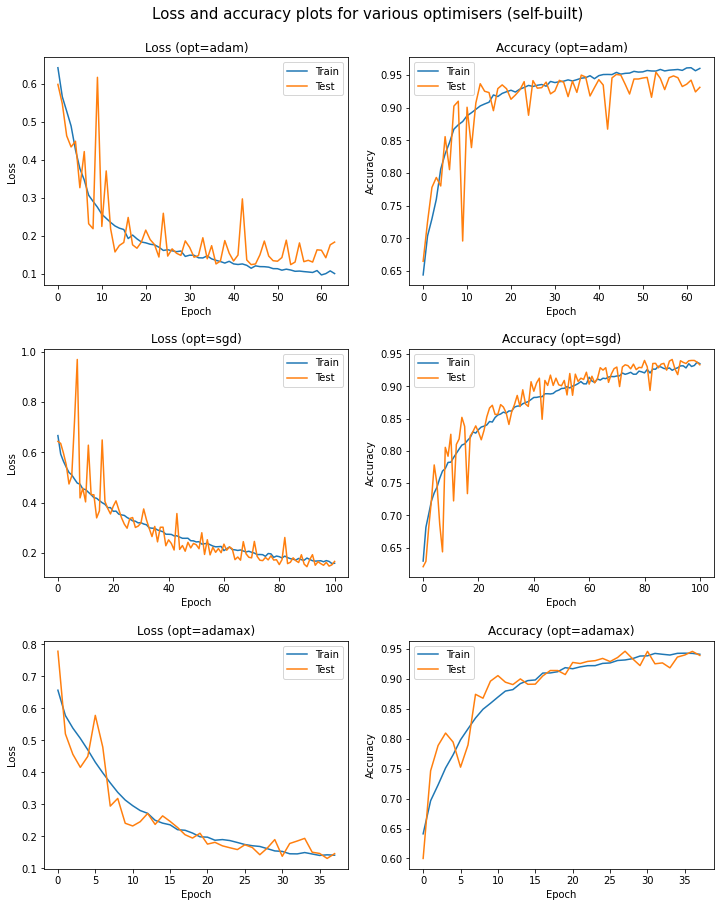

In [ ]:
# Plot loss and accuracy for each optimiser
(fig, axs) = plt.subplots(3, 2, figsize=(12,14))

plt.suptitle("Loss and accuracy plots for various optimisers (self-built)", fontsize=15)
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.28)

axs_it = iter(axs.ravel())

titles = ["adam", "sgd", "adamax"]

for (key, ax_title) in zip(selfbuilt_opt_dict.keys(), titles): 
  # Plot loss
  cur_ax = next(axs_it)
  cur_ax.plot(selfbuilt_opt_dict[key]['loss'])
  cur_ax.plot(selfbuilt_opt_dict[key]['val_loss'])

  cur_ax.set_title(f"Loss (opt={ax_title})")
  cur_ax.set_ylabel('Loss')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])

  # Plot accuracy 
  cur_ax = next(axs_it)
  cur_ax.plot(selfbuilt_opt_dict[key]['accuracy'])
  cur_ax.plot(selfbuilt_opt_dict[key]['val_accuracy'])

  cur_ax.set_title(f"Accuracy (opt={ax_title})")
  cur_ax.set_ylabel('Accuracy')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])


#### Learning rate

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
learning_rate_names = ['01', '001', '0001']
selfbuilt_lr_dict = {}

for lr, name in zip(learning_rates, learning_rate_names):

    print(f"------------ \n Fitting learning rate {lr} \n")

    # Instantiate the model
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, input_shape=(128, 128, 3), 
                    padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    # Specify optimiser
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Set up callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=10)
    model_save = ModelCheckpoint(f'/content/drive/MyDrive/Selfbuilt_{lr}.hdf5', save_best_only=True)

    # Train the model
    history = model.fit(train_ds, epochs=500, 
                        validation_data=val_ds,
                        callbacks = [early_stopping_monitor, model_save])

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

    selfbuilt_lr_dict[f"lr={str(lr)}"] = history.history
  
    # Save the dictionary as numpy file for future visualisations
    np.save(f'/content/drive/My Drive/selfbuilt_lr_dict_{lr}', selfbuilt_lr_dict)

# Save the dictionary as numpy file for future visualisations
np.save(f'/content/drive/My Drive/selfbuilt_lr_dict', selfbuilt_lr_dict)

------------ 
 Fitting learning rate 0.01 

Epoch 1/500
397/500 [======================>.......] - ETA: 18s - loss: 0.6908 - accuracy: 0.5935

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 112s 202ms/step - loss: 0.6774 - accuracy: 0.6051 - val_loss: 0.6491 - val_accuracy: 0.6201
Epoch 2/500
500/500 [==============================] - 98s 196ms/step - loss: 0.5985 - accuracy: 0.6770 - val_loss: 0.7577 - val_accuracy: 0.6498
Epoch 3/500
500/500 [==============================] - 97s 195ms/step - loss: 0.5537 - accuracy: 0.7146 - val_loss: 0.5155 - val_accuracy: 0.7521
Epoch 4/500
500/500 [==============================] - 97s 193ms/step - loss: 0.5113 - accuracy: 0.7496 - val_loss: 1.2009 - val_accuracy: 0.5160
Epoch 5/500
500/500 [==============================] - 97s 195ms/step - loss: 0.4808 - accuracy: 0.7648 - val_loss: 0.4687 - val_accuracy: 0.7726
Epoch 6/500
500/500 [==============================] - 98s 195ms/step - loss: 0.4376 - accuracy: 0.7954 - val_loss: 0.8658 - val_accuracy: 0.6163
Epoch 7/500
500/500 [==============================] - 97s 194ms/step - loss: 0.4118 - accuracy: 0.8103 - val_loss: 0.5223 - val_accura

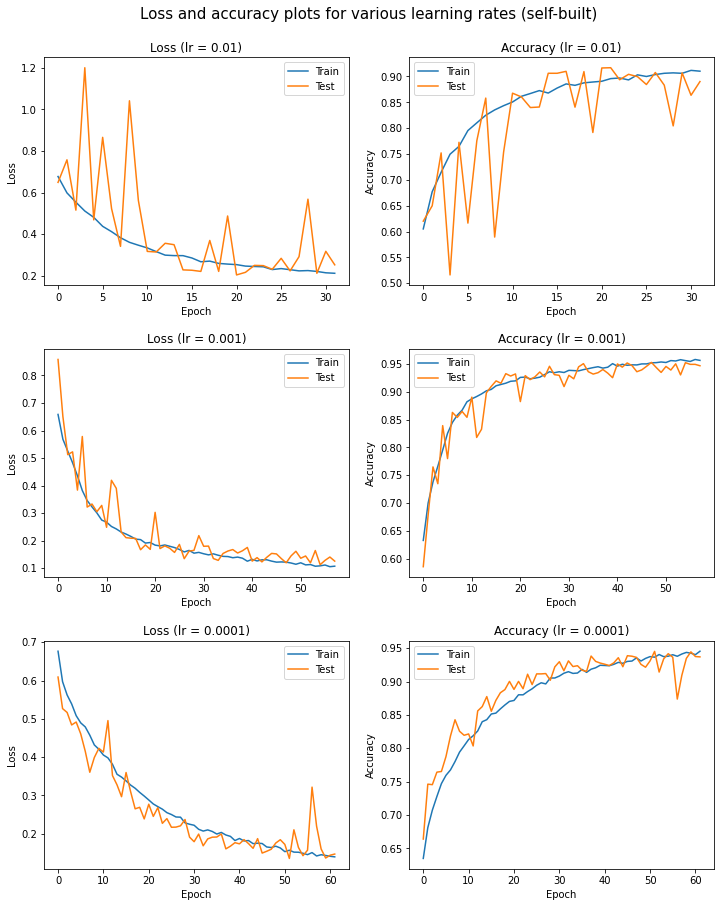

In [ ]:
# Plot loss and accuracy for each learning rate
(fig, axs) = plt.subplots(3, 2, figsize=(12,14))

plt.suptitle("Loss and accuracy plots for various learning rates (self-built)", fontsize=15)
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.28)

axs_it = iter(axs.ravel())

titles = ["lr = 0.01", "lr = 0.001", "lr = 0.0001"]

for (key, ax_title) in zip(selfbuilt_lr_dict.keys(), titles): 
  # Plot loss
  cur_ax = next(axs_it)
  cur_ax.plot(selfbuilt_lr_dict[key]['loss'])
  cur_ax.plot(selfbuilt_lr_dict[key]['val_loss'])

  cur_ax.set_title(f"Loss ({ax_title})")
  cur_ax.set_ylabel('Loss')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])

  # Plot accuracy 
  cur_ax = next(axs_it)
  cur_ax.plot(selfbuilt_lr_dict[key]['accuracy'])
  cur_ax.plot(selfbuilt_lr_dict[key]['val_accuracy'])

  cur_ax.set_title(f"Accuracy ({ax_title})")
  cur_ax.set_ylabel('Accuracy')
  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Train', 'Test'])


#### Activation function
Swap ReLU with LeakyReLU

In [ ]:
# Instantiate the model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, input_shape=(128, 128, 3), 
                padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model.add(LeakyReLU())    
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, padding='same'))
model.add(LeakyReLU())    
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model.add(LeakyReLU())    
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
model.add(LeakyReLU())    
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

# Specify optimiser
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

# Set up callbacks
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=10)
model_save = ModelCheckpoint(f'/content/drive/MyDrive/Selfbuilt_leaky.hdf5', save_best_only=True)

# Train the model
history = model.fit(train_ds, epochs=500, 
                    validation_data=val_ds,
                    callbacks = [early_stopping_monitor, model_save])

# Print best results
print("Lowest val_loss: ", min(history.history['val_loss']))
print("Best val_accuracy: ", max(history.history['val_accuracy']))

selfbuilt_lr_dict["leaky"] = history.history

# Save the dictionary as numpy file for future visualisations
np.save(f'/content/drive/My Drive/selfbuilt_lr_dict', selfbuilt_lr_dict)

Epoch 1/500
338/500 [===================>..........] - ETA: 30s - loss: 0.6966 - accuracy: 0.5920

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 104s 206ms/step - loss: 0.6791 - accuracy: 0.6021 - val_loss: 1.0150 - val_accuracy: 0.5453
Epoch 2/500
500/500 [==============================] - 100s 200ms/step - loss: 0.6140 - accuracy: 0.6566 - val_loss: 0.6026 - val_accuracy: 0.6648
Epoch 3/500
500/500 [==============================] - 99s 198ms/step - loss: 0.5710 - accuracy: 0.6978 - val_loss: 0.8213 - val_accuracy: 0.6411
Epoch 4/500
500/500 [==============================] - 99s 198ms/step - loss: 0.5286 - accuracy: 0.7362 - val_loss: 0.5127 - val_accuracy: 0.7596
Epoch 5/500
500/500 [==============================] - 99s 198ms/step - loss: 0.4890 - accuracy: 0.7616 - val_loss: 0.5199 - val_accuracy: 0.7451
Epoch 6/500
500/500 [==============================] - 99s 197ms/step - loss: 0.4588 - accuracy: 0.7834 - val_loss: 0.5422 - val_accuracy: 0.7334
Epoch 7/500
500/500 [==============================] - 99s 199ms/step - loss: 0.4237 - accuracy: 0.8043 - val_loss: 0.4266 - val_accur

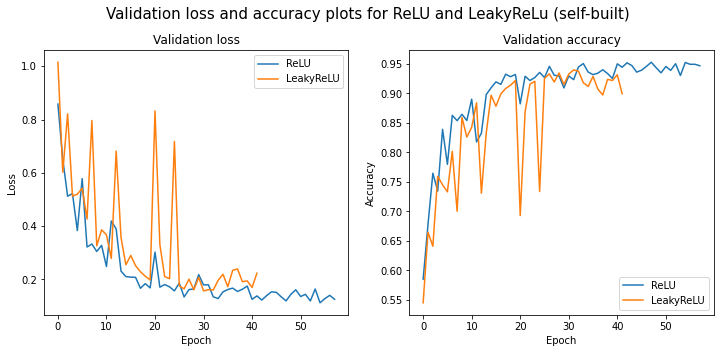

In [ ]:
# Plot loss and accuracy for each learning rate
(fig, axs) = plt.subplots(1, 2, figsize=(12,5))

plt.suptitle("Validation loss and accuracy plots for ReLU and LeakyReLu (self-built)", fontsize=15)
plt.subplots_adjust(top=0.86, wspace=0.2, hspace=0.28)

axs_it = iter(axs.ravel())

# Plot loss
cur_ax = next(axs_it)
cur_ax.plot(selfbuilt_lr_dict['lr=0.001']['val_loss'])
cur_ax.plot(selfbuilt_lr_dict['leaky']['val_loss'])

cur_ax.set_title(f"Validation loss")
cur_ax.set_ylabel('Loss')
cur_ax.set_xlabel('Epoch')
cur_ax.legend(['ReLU', 'LeakyReLU'])

# Plot accuracy 
cur_ax = next(axs_it)
cur_ax.plot(selfbuilt_lr_dict['lr=0.001']['val_accuracy'])
cur_ax.plot(selfbuilt_lr_dict['leaky']['val_accuracy'])

cur_ax.set_title(f"Validation accuracy")
cur_ax.set_ylabel('Accuracy')
cur_ax.set_xlabel('Epoch')
cur_ax.legend(['ReLU', 'LeakyReLU']);

In this CNN, LeakyReLU does not seem to offer performance improvements.

# Model comparison
- GradCam

## View model architectures

In [ ]:
# Set up MobileNet
MobileNet_model = tf.keras.applications.MobileNet(include_top=True, 
                                        weights=None, 
                                        input_shape=(128, 128, 3),
                                        classes=1,
                                        classifier_activation='sigmoid')
# Set up Xception
Xception_model = tf.keras.applications.Xception(include_top=True, 
                                        weights=None, 
                                        input_shape=(128, 128, 3),
                                        classes=1,
                                        classifier_activation='sigmoid')
# Set up the self designed model
inputs = keras.Input(shape=(128, 128, 3))
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
x = MaxPool2D(2)(x)
x = BatchNormalization()(x)

x = Dropout(0.25)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(2)(x)
x = BatchNormalization()(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(2)(x)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(2)(x)
x = BatchNormalization()(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(2)(x)
x = BatchNormalization()(x)

x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='sigmoid')(x)

Selfbuilt_model = keras.Model(inputs=inputs, outputs=outputs, name="catsdogs_model")

In [ ]:
# See summary of MobileNet
MobileNet_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

In [ ]:
# See summary of Xception
Xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [ ]:
# See summary of own design model
Selfbuilt_model.summary()

Model: "catsdogs_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)     

## Fit the models

In [ ]:
models = [MobileNet_model, Xception_model, Selfbuilt_model]
model_names = ["MobileNet", "Xception", "Selfbuilt"]
compare_dict = {}

for model, name in zip(models, model_names):
    
    print(f"------------ \n Fitting model {name} \n")

    # Specify optimiser
    if name == "Xception":
      opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    else:
      opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics="accuracy")

    # Set up callbacks
    model_save = ModelCheckpoint(f'/content/drive/MyDrive/Best_{name}.hdf5', save_best_only=True)

    # Train the model
    history = model.fit(train_ds, epochs=65, 
                        validation_data=val_ds,
                        callbacks = [model_save])

    # Print best results
    print("Lowest val_loss: ", min(history.history['val_loss']))
    print("Best val_accuracy: ", max(history.history['val_accuracy']))

    compare_dict[f"{name}"] = history.history
  
    # Save the dictionary checkpoint
    np.save(f'/content/drive/My Drive/compare_dict_{name}', compare_dict)

# Save the dictionary as numpy file in case of runtime error
np.save(f'/content/drive/My Drive/compare_dict', compare_dict)

------------ 
 Fitting model MobileNet 

Epoch 1/65
396/500 [======================>.......] - ETA: 22s - loss: 0.7020 - accuracy: 0.5760

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

500/500 [==============================] - 136s 240ms/step - loss: 0.6920 - accuracy: 0.5861 - val_loss: 0.6927 - val_accuracy: 0.5260
Epoch 2/65
500/500 [==============================] - 118s 236ms/step - loss: 0.6420 - accuracy: 0.6311 - val_loss: 0.7163 - val_accuracy: 0.6208
Epoch 3/65
500/500 [==============================] - 120s 239ms/step - loss: 0.6154 - accuracy: 0.6563 - val_loss: 0.6672 - val_accuracy: 0.6576
Epoch 4/65
500/500 [==============================] - 117s 234ms/step - loss: 0.5868 - accuracy: 0.6845 - val_loss: 0.7219 - val_accuracy: 0.6688
Epoch 5/65
500/500 [==============================] - 116s 231ms/step - loss: 0.5503 - accuracy: 0.7164 - val_loss: 0.9531 - val_accuracy: 0.6408
Epoch 6/65
500/500 [==============================] - 117s 235ms/step - loss: 0.5267 - accuracy: 0.7300 - val_loss: 0.4864 - val_accuracy: 0.7591
Epoch 7/65
500/500 [==============================] - 115s 231ms/step - loss: 0.4990 - accuracy: 0.7536 - val_loss: 0.6767 - val_accura

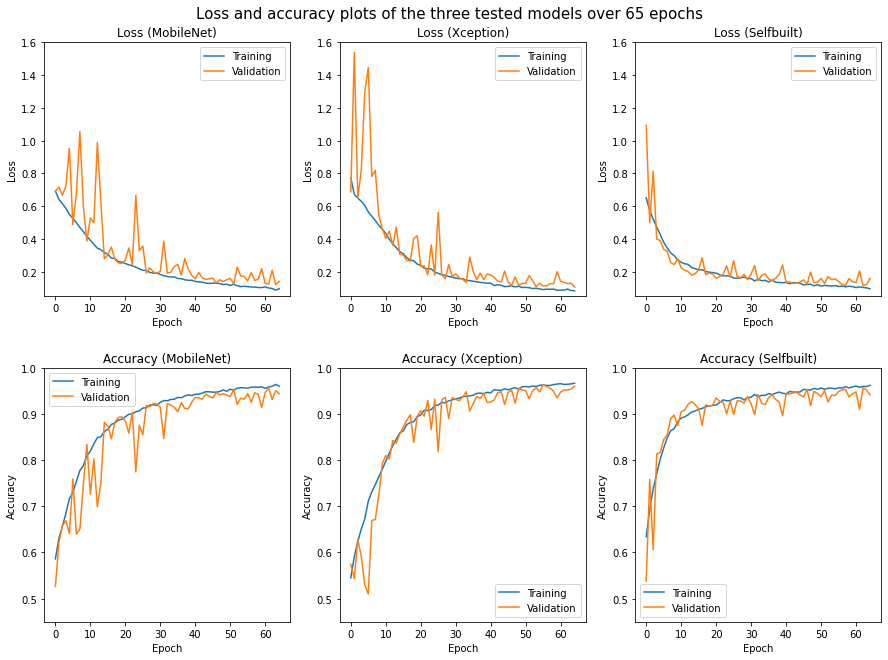

In [ ]:
compare_dict = np.load('/content/drive/My Drive/compare_dict.npy', allow_pickle='TRUE').item()

# Plot loss and accuracy for each model
(fig, axs) = plt.subplots(2, 3, figsize=(15,10))

plt.suptitle("Loss and accuracy plots of the three tested models over 65 epochs", fontsize=15)
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.28)
axs_it = iter(axs.ravel())

keys = ['MobileNet', 'Xception', 'Selfbuilt']*2
y_axis_training = ['loss', 'loss', 'loss', 'accuracy', 'accuracy', 'accuracy']
y_axis_validation = ['val_loss', 'val_loss', 'val_loss', 
                     'val_accuracy', 'val_accuracy', 'val_accuracy']
titles = ['Loss (MobileNet)', 'Loss (Xception)', 'Loss (Selfbuilt)',
          'Accuracy (MobileNet)', 'Accuracy (Xception)', 'Accuracy (Selfbuilt)']
ylabels = ['Loss', 'Loss', 'Loss', 'Accuracy', 'Accuracy', 'Accuracy']
plot_spec = zip(keys, y_axis_training, y_axis_validation, titles, ylabels)

for key, train, val, title, ylabel in plot_spec: 

  # Plot training and validation lines
  cur_ax = next(axs_it)
  cur_ax.plot(compare_dict[key][train])
  cur_ax.plot(compare_dict[key][val])
  
  # Add labels, title, and legend
  cur_ax.set_title(title)
  cur_ax.set_ylabel(ylabel)

  if ylabel == 'Loss':
    cur_ax.set_ylim(0.05, 1.6)
  elif ylabel == 'Accuracy':
    cur_ax.set_ylim(0.45, 1.0)

  cur_ax.set_xlabel('Epoch')
  cur_ax.legend(['Training', 'Validation'])


## Test the models

In [ ]:
# Load the best models
MobileNet_model = keras.models.load_model("/content/drive/MyDrive/Best_MobileNet.hdf5")
Xception_model = keras.models.load_model("/content/drive/MyDrive/Best_Xception.hdf5")
Selfbuilt_model = keras.models.load_model("/content/drive/MyDrive/Best_Selfbuilt.hdf5")

In [ ]:
# Test model
test_directory = "/content/cats_dogs/test"

test_datagen = ImageDataGenerator(rescale=1./255) 

test_ds = test_datagen.flow_from_directory(
    test_directory,
    target_size=(128, 128),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

Found 5000 images belonging to 2 classes.


In [ ]:
# Evaluate on test data
models = [MobileNet_model, Xception_model, Selfbuilt_model]
model_names = ["MobileNet", "Xception", "Selfbuilt"]

for model, name in zip(models, model_names):
    print(f"Evaluating model {name}")
    scores = model.evaluate(test_ds)
    print(f"{model.metrics_names[0]}: {scores[0]}")
    print(f"{model.metrics_names[1]}: {scores[1]*100}% \n")

Evaluating model MobileNet
157/157 [==============================] - 28s 104ms/step - loss: 0.1208 - accuracy: 0.9562
loss: 0.12083713710308075
accuracy: 95.62000036239624% 

Evaluating model Xception
157/157 [==============================] - 18s 105ms/step - loss: 0.1002 - accuracy: 0.9562
loss: 0.10021110624074936
accuracy: 95.62000036239624% 

Evaluating model Selfbuilt
157/157 [==============================] - 20s 121ms/step - loss: 0.1082 - accuracy: 0.9562
loss: 0.10817237198352814
accuracy: 95.62000036239624% 



## Compare predictions 




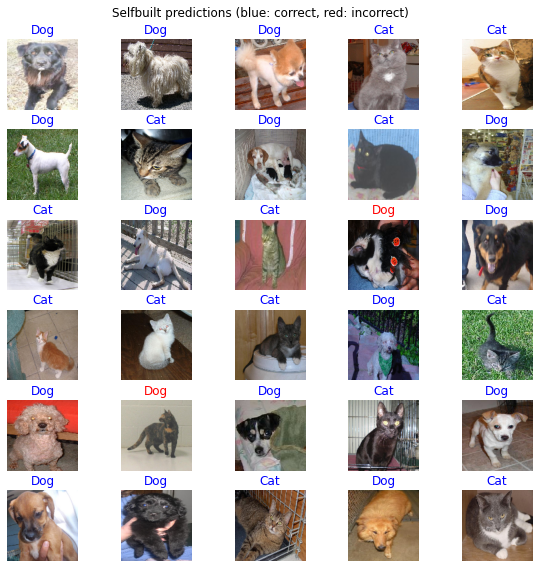

In [ ]:
plt.figure(figsize=(10,9))
plt.suptitle("Selfbuilt predictions (blue: correct, red: incorrect)")
plt.subplots_adjust(top=0.93, wspace=0.1, hspace=0.28)

img_batch, label_batch = next(iter(val_ds))

predicted_batch = Selfbuilt_model.predict(img_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = (predicted_batch > 0.5).astype(int)

label_name = np.array(['Cat', 'Dog'])
predicted_class_names = label_name[predicted_ids]

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(img_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')

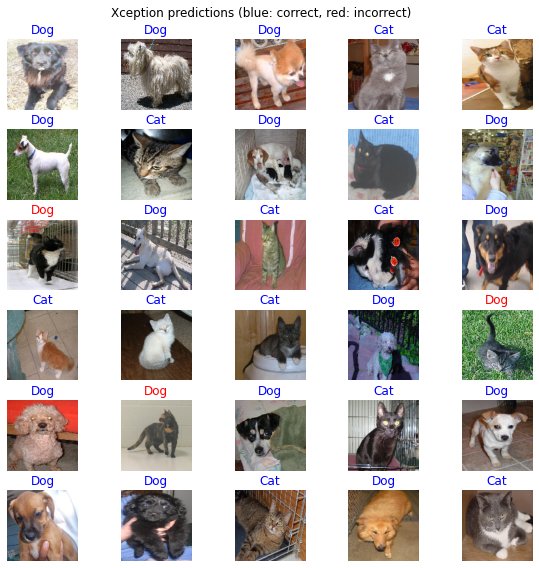

In [ ]:
plt.figure(figsize=(10,9))
plt.suptitle("Xception predictions (blue: correct, red: incorrect)")
plt.subplots_adjust(top=0.93, wspace=0.1, hspace=0.28)

predicted_batch = Xception_model.predict(img_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = (predicted_batch > 0.5).astype(int)

label_name = np.array(['Cat', 'Dog'])
predicted_class_names = label_name[predicted_ids]

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(img_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')

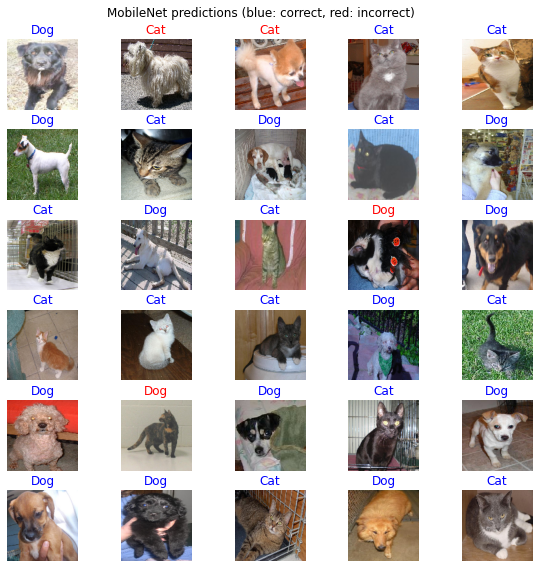

In [ ]:
plt.figure(figsize=(10,9))
plt.suptitle("MobileNet predictions (blue: correct, red: incorrect)")
plt.subplots_adjust(top=0.93, wspace=0.1, hspace=0.28)

predicted_batch = MobileNet_model.predict(img_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = (predicted_batch > 0.5).astype(int)

label_name = np.array(['Cat', 'Dog'])
predicted_class_names = label_name[predicted_ids]

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(img_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')

## Confusion matrix

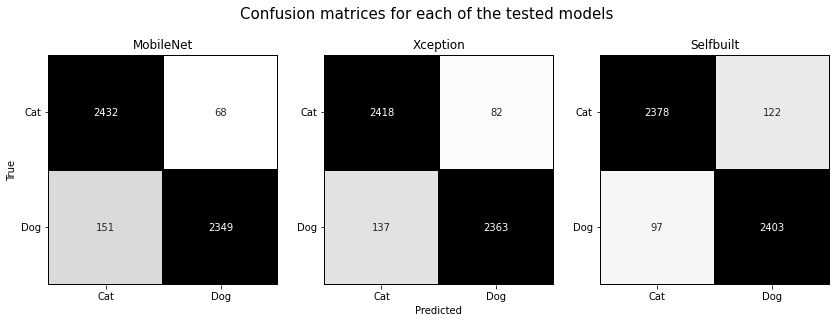

In [ ]:
# Get predictions for each model
MobileNet_predictions = MobileNet_model.predict(x=test_ds, steps=len(test_ds))
Xception_predictions = Xception_model.predict(x=test_ds, steps=len(test_ds))
Selfbuilt_predictions = Selfbuilt_model.predict(x=test_ds, steps=len(test_ds))

# Get confusion matrices for each model
MobileNet_cm = confusion_matrix(y_true=test_ds.classes, y_pred=(MobileNet_predictions > 0.5).astype('int32'))
Xception_cm = confusion_matrix(y_true=test_ds.classes, y_pred=(Xception_predictions > 0.5).astype('int32'))
Selfbuilt_cm = confusion_matrix(y_true=test_ds.classes, y_pred=(Selfbuilt_predictions > 0.5).astype('int32'))

# Set up the figure
(fig, axs) = plt.subplots(1, 3, figsize=(14,5))

plt.suptitle("Confusion matrices for each of the tested models", fontsize=15)
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.28)
axs_it = iter(axs.ravel())

# Plot spec
cms = [MobileNet_cm, Xception_cm, Selfbuilt_cm]
titles = ['MobileNet', 'Xception', 'Selfbuilt']
ylabels = ['True', '', '']
xlabels = ['', 'Predicted', '']
labels = ['Cat', 'Dog']

for cm, title, ylabel, xlabel in zip(cms, titles, ylabels, xlabels):
  cur_ax = next(axs_it)
  sns.heatmap(cm, fmt='.0f', vmin=70, vmax=400, square=True, annot=True, 
              cbar=False, cmap="Greys", linecolor='black', linewidth=1, 
              yticklabels=labels, xticklabels=labels,
              ax = cur_ax)
  cur_ax.set_title(title)
  cur_ax.set_ylabel(ylabel)
  cur_ax.set_xlabel(xlabel)
  cur_ax.set_yticklabels(labels=labels, rotation=0);

## GradCam

In [ ]:
def grad_cam(model, img_array, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Get gradient of the top predicted class for input image wrt output feature map of last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Get vector with mean intensity of the gradient over feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by importance wrt top predicted class & sum
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap for visualisation
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Cat/164.jpg
Class activation map for:  cat
Probability:  0.9998343


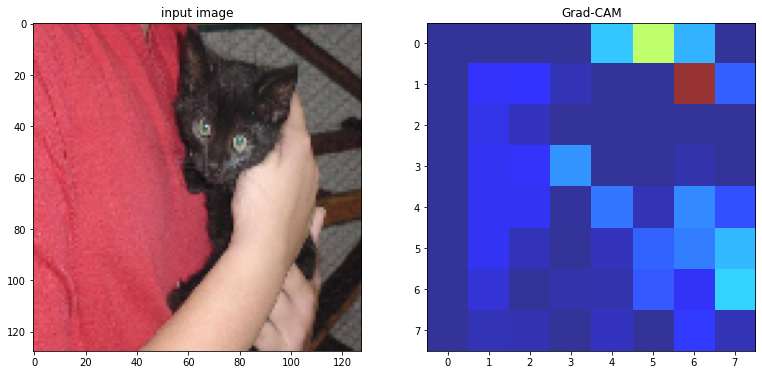

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Cat", "164.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

layer_names = ['conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8']

gradcam = grad_cam(Selfbuilt_model, image, layer_name='conv2d_4')

print("Image: ", image_path)

prob = Selfbuilt_model.predict(image)
pred_label = np.round(prob[0][0]).astype(int)
if pred_label == 0:
    prob[0][0] = 1-prob[0][0]

labels = {0: 'cat', 1: 'dog'}
print("Class activation map for: ", labels[pred_label])
print("Probability: ", prob[0][0])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
plt.subplot(131)
plt.imshow(orig_image)
plt.title("input image")
plt.subplot(132)
plt.imshow(gradcam,alpha=0.8,cmap="jet")
plt.title("Grad-CAM")
plt.show()

(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Cat/164.jpg
Class activation map for:  cat
Probability:  0.9998343


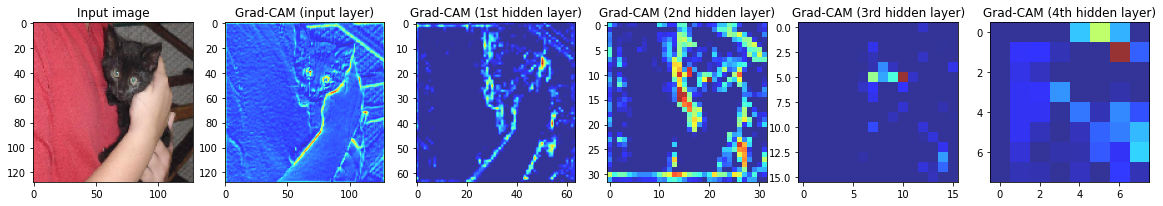

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Cat", "164.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

print("Image: ", image_path)

prob = Selfbuilt_model.predict(image)
pred_label = np.round(prob[0][0]).astype(int)
if pred_label == 0:
    prob[0][0] = 1-prob[0][0]

labels = {0: 'cat', 1: 'dog'}
print("Class activation map for: ", labels[pred_label])
print("Probability: ", prob[0][0])

fig, axs = plt.subplots(1, 6, figsize=(20,5))
axs_it = iter(axs.ravel())

cur_ax = next(axs_it)
cur_ax.imshow(orig_image)
cur_ax.set_title("Input image")

layer_names = ['conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8']
titles = ['input layer', '1st hidden layer', '2nd hidden layer', '3rd hidden layer', '4th hidden layer']

for layer_name, title in zip(layer_names, titles):
  cur_ax = next(axs_it)
  gradcam = grad_cam(Selfbuilt_model, image, layer_name=layer_name)
  cur_ax.imshow(gradcam,alpha=0.8,cmap="jet")
  cur_ax.set_title(f"Grad-CAM ({title})");

(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Dog/201.jpg
Class activation map for:  dog
Probability:  0.9876258


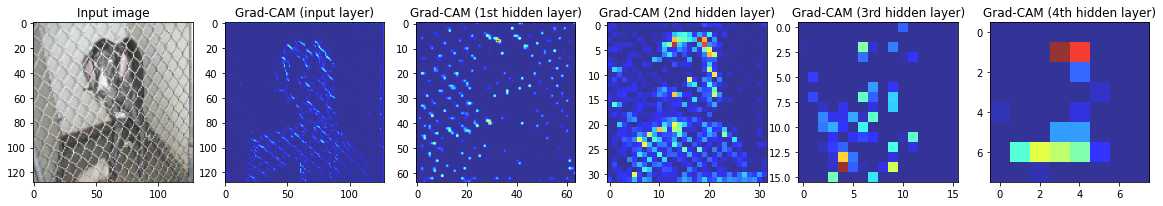

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Dog", "201.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

print("Image: ", image_path)

prob = Selfbuilt_model.predict(image)
pred_label = np.round(prob[0][0]).astype(int)
if pred_label == 0:
    prob[0][0] = 1-prob[0][0]

labels = {0: 'cat', 1: 'dog'}
print("Class activation map for: ", labels[pred_label])
print("Probability: ", prob[0][0])

fig, axs = plt.subplots(1, 6, figsize=(20,5))
axs_it = iter(axs.ravel())

cur_ax = next(axs_it)
cur_ax.imshow(orig_image)
cur_ax.set_title("Input image")

layer_names = ['conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8']
titles = ['input layer', '1st hidden layer', '2nd hidden layer', '3rd hidden layer', '4th hidden layer']

for layer_name, title in zip(layer_names, titles):
  cur_ax = next(axs_it)
  gradcam = grad_cam(Selfbuilt_model, image, layer_name=layer_name)
  cur_ax.imshow(gradcam,alpha=0.8,cmap="jet")
  cur_ax.set_title(f"Grad-CAM ({title})");

(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Dog/100.jpg
Class activation map for:  dog
Probability:  0.9999174


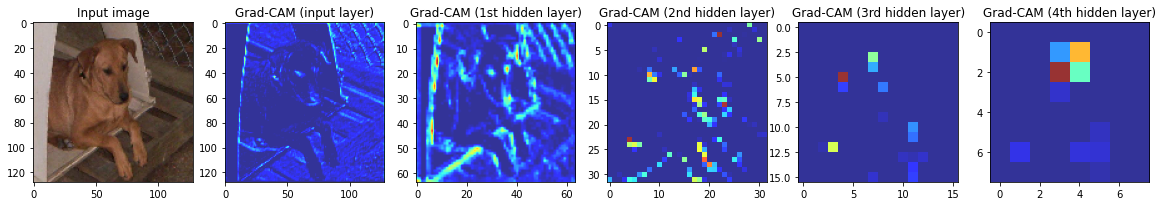

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Dog", "100.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

print("Image: ", image_path)

prob = Selfbuilt_model.predict(image)
pred_label = np.round(prob[0][0]).astype(int)
if pred_label == 0:
    prob[0][0] = 1-prob[0][0]

labels = {0: 'cat', 1: 'dog'}
print("Class activation map for: ", labels[pred_label])
print("Probability: ", prob[0][0])

fig, axs = plt.subplots(1, 6, figsize=(20,5))
axs_it = iter(axs.ravel())

cur_ax = next(axs_it)
cur_ax.imshow(orig_image)
cur_ax.set_title("Input image")

layer_names = ['conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8']
titles = ['input layer', '1st hidden layer', '2nd hidden layer', '3rd hidden layer', '4th hidden layer']

for layer_name, title in zip(layer_names, titles):
  cur_ax = next(axs_it)
  gradcam = grad_cam(Selfbuilt_model, image, layer_name=layer_name)
  cur_ax.imshow(gradcam,alpha=0.8,cmap="jet")
  cur_ax.set_title(f"Grad-CAM ({title})");

(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Dog/100.jpg
Class activation map for:  dog
Probability:  0.98293465


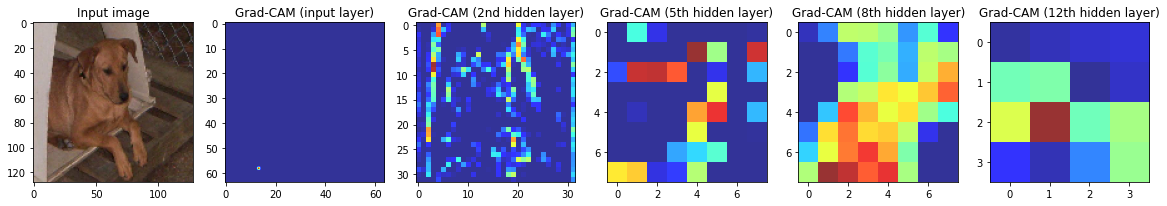

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Dog", "100.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

print("Image: ", image_path)

prob = MobileNet_model.predict(image)
pred_label = np.round(prob[0][0]).astype(int)
if pred_label == 0:
    prob[0][0] = 1-prob[0][0]

labels = {0: 'cat', 1: 'dog'}
print("Class activation map for: ", labels[pred_label])
print("Probability: ", prob[0][0])

fig, axs = plt.subplots(1, 6, figsize=(20,5))
axs_it = iter(axs.ravel())

cur_ax = next(axs_it)
cur_ax.imshow(orig_image)
cur_ax.set_title("Input image")

layer_names = ['conv1_relu', 'conv_pw_3_relu', 'conv_pw_6_relu', 'conv_pw_9_relu', 'conv_pw_13_relu']
#layer_names = ['conv1', 'conv_pw_3', 'conv_pw_6', 'conv_pw_9', 'conv_pw_13']
titles = ['input layer', '2nd hidden layer', '5th hidden layer', '8th hidden layer', '12th hidden layer']

for layer_name, title in zip(layer_names, titles):
  cur_ax = next(axs_it)
  gradcam = grad_cam(MobileNet_model, image, layer_name=layer_name)
  cur_ax.imshow(gradcam,alpha=0.8,cmap="jet")
  cur_ax.set_title(f"Grad-CAM ({title})");

(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Dog/100.jpg
Class activation map for:  dog
Probability:  0.99976414


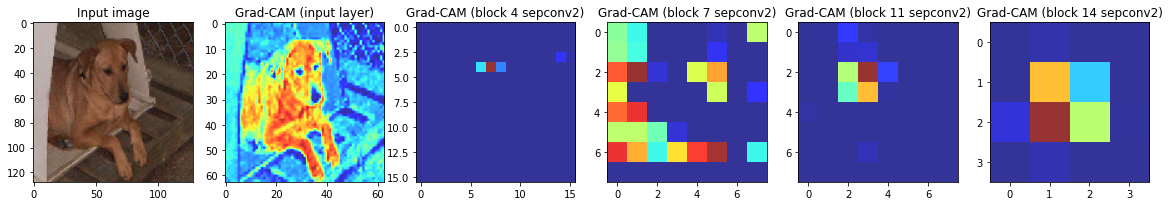

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Dog", "100.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

print("Image: ", image_path)

prob = Xception_model.predict(image)
pred_label = np.round(prob[0][0]).astype(int)
if pred_label == 0:
    prob[0][0] = 1-prob[0][0]

labels = {0: 'cat', 1: 'dog'}
print("Class activation map for: ", labels[pred_label])
print("Probability: ", prob[0][0])

fig, axs = plt.subplots(1, 6, figsize=(20,5))
axs_it = iter(axs.ravel())

cur_ax = next(axs_it)
cur_ax.imshow(orig_image)
cur_ax.set_title("Input image")

layer_names = ['block1_conv1_act', 'block4_sepconv2_act', 'block7_sepconv3_act', 'block11_sepconv2_act', 'block14_sepconv2_act']
#layer_names = ['conv1', 'conv_pw_3', 'conv_pw_6', 'conv_pw_9', 'conv_pw_13']
titles = ['input layer', 'block 4 sepconv2', 'block 7 sepconv2', 'block 11 sepconv2', 'block 14 sepconv2']

for layer_name, title in zip(layer_names, titles):
  cur_ax = next(axs_it)
  gradcam = grad_cam(Xception_model, image, layer_name=layer_name)
  cur_ax.imshow(gradcam, alpha=0.8, cmap="jet")
  cur_ax.set_title(f"Grad-CAM ({title})");

(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Dog/222.jpg
Class activation map for:  MobileNet dog
Probability:  0.7849186
Class activation map for:  Xception dog
Probability:  0.9995757
Class activation map for:  Selfbuilt dog
Probability:  0.95855916


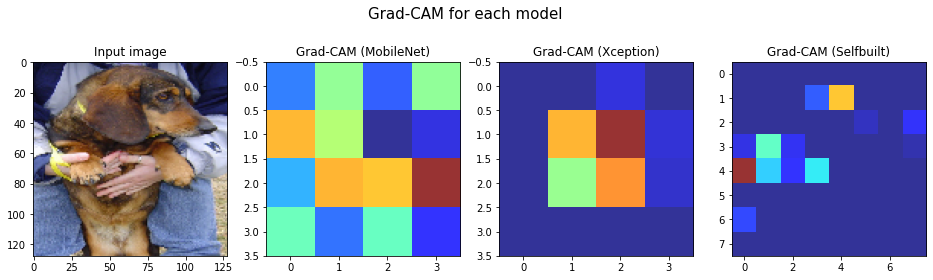

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Dog", "222.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

print("Image: ", image_path)

fig, axs = plt.subplots(1, 4, figsize=(16,5))
axs_it = iter(axs.ravel())

plt.suptitle("Grad-CAM for each model", fontsize=15)
plt.subplots_adjust(top=0.99)

cur_ax = next(axs_it)
cur_ax.imshow(orig_image)
cur_ax.set_title("Input image")

models = [MobileNet_model, Xception_model, Selfbuilt_model]
titles = ["MobileNet", "Xception", "Selfbuilt"]
layer_names = ["conv_pw_13_relu", "block14_sepconv2_act", "conv2d_8"]

for model, title, layer_name in zip(models, titles, layer_names):
  prob = model.predict(image)
  pred_label = np.round(prob[0][0]).astype(int)
  if pred_label == 0:
      prob[0][0] = 1-prob[0][0]

  labels = {0: 'cat', 1: 'dog'}
  print("Class activation map for: ", title, labels[pred_label])
  print("Probability: ", prob[0][0])

  cur_ax = next(axs_it)
  gradcam = grad_cam(model, image, layer_name=layer_name)
  cur_ax.imshow(gradcam, alpha=0.8, cmap="jet")
  cur_ax.set_title(f"Grad-CAM ({title})");

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Dog", "225.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

print("Image: ", image_path)

fig, axs = plt.subplots(1, 4, figsize=(16,5))
axs_it = iter(axs.ravel())

plt.suptitle("Grad-CAM for each model", fontsize=15)
plt.subplots_adjust(top=0.99)

cur_ax = next(axs_it)
cur_ax.imshow(orig_image)
cur_ax.set_title("Input image")

models = [MobileNet_model, Xception_model, Selfbuilt_model]
titles = ["MobileNet", "Xception", "Selfbuilt"]
layer_names = ["conv_pw_13_relu", "block14_sepconv2_act", "conv2d_8"]

for model, title, layer_name in zip(models, titles, layer_names):
  prob = model.predict(image)
  pred_label = np.round(prob[0][0]).astype(int)
  if pred_label == 0:
      prob[0][0] = 1-prob[0][0]

  labels = {0: 'cat', 1: 'dog'}
  print("Class activation map for: ", title, labels[pred_label])
  print("Probability: ", prob[0][0])

  cur_ax = next(axs_it)
  gradcam = grad_cam(model, image, layer_name=layer_name)
  cur_ax.imshow(gradcam, alpha=0.8, cmap="jet")
  cur_ax.set_title(f"Grad-CAM ({title})");

(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Dog/225.jpg
Class activation map for:  MobileNet dog
Probability:  0.68096375
Class activation map for:  Xception dog
Probability:  0.7185535
Class activation map for:  Selfbuilt cat
Probability:  0.9416335


(1, 128, 128, 3)
Image:  /content/cats_dogs/train/Dog/238.jpg
Class activation map for:  MobileNet dog
Probability:  0.5969326
Class activation map for:  Xception dog
Probability:  0.96542925
Class activation map for:  Selfbuilt dog
Probability:  0.9999324


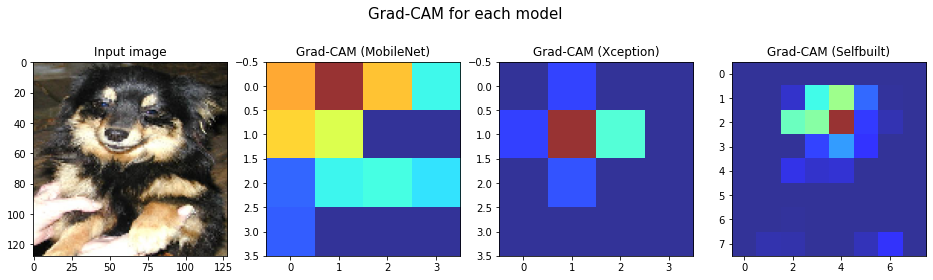

In [ ]:
# Specify image path
image_path = os.path.join("/content/cats_dogs/train/Dog", "238.jpg")

# Load the image in target size
orig_image = load_img(image_path, target_size=(128, 128))

# Preprocess the image
image = np.expand_dims(img_to_array(orig_image), axis=0) / 255.0
print(image.shape)

print("Image: ", image_path)

fig, axs = plt.subplots(1, 4, figsize=(16,5))
axs_it = iter(axs.ravel())

plt.suptitle("Grad-CAM for each model", fontsize=15)
plt.subplots_adjust(top=0.99)

cur_ax = next(axs_it)
cur_ax.imshow(orig_image)
cur_ax.set_title("Input image")

models = [MobileNet_model, Xception_model, Selfbuilt_model]
titles = ["MobileNet", "Xception", "Selfbuilt"]
layer_names = ["conv_pw_13_relu", "block14_sepconv2_act", "conv2d_8"]

for model, title, layer_name in zip(models, titles, layer_names):
  prob = model.predict(image)
  pred_label = np.round(prob[0][0]).astype(int)
  if pred_label == 0:
      prob[0][0] = 1-prob[0][0]

  labels = {0: 'cat', 1: 'dog'}
  print("Class activation map for: ", title, labels[pred_label])
  print("Probability: ", prob[0][0])

  cur_ax = next(axs_it)
  gradcam = grad_cam(model, image, layer_name=layer_name)
  cur_ax.imshow(gradcam, alpha=0.8, cmap="jet")
  cur_ax.set_title(f"Grad-CAM ({title})");